In [12]:
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm 
from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import shap

In [2]:
def column_adjustor(dataset_column):
    codes, uniques = pd.factorize(dataset_column)
    return pd.Series(codes, index=dataset_column.index)

## Base Features

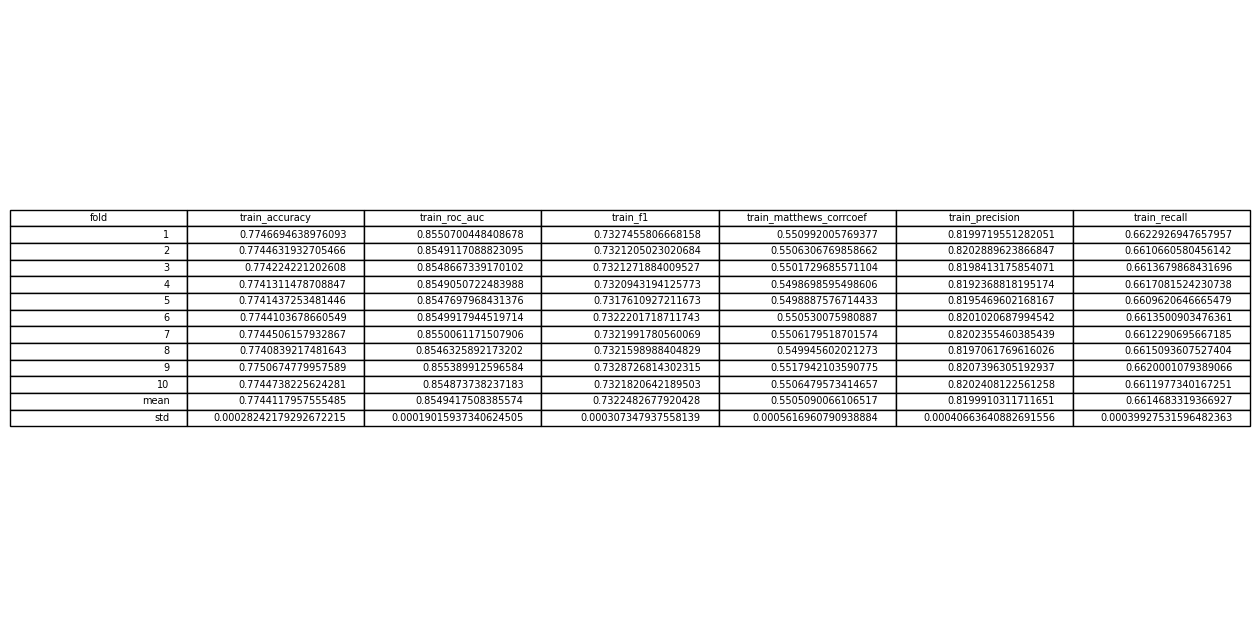

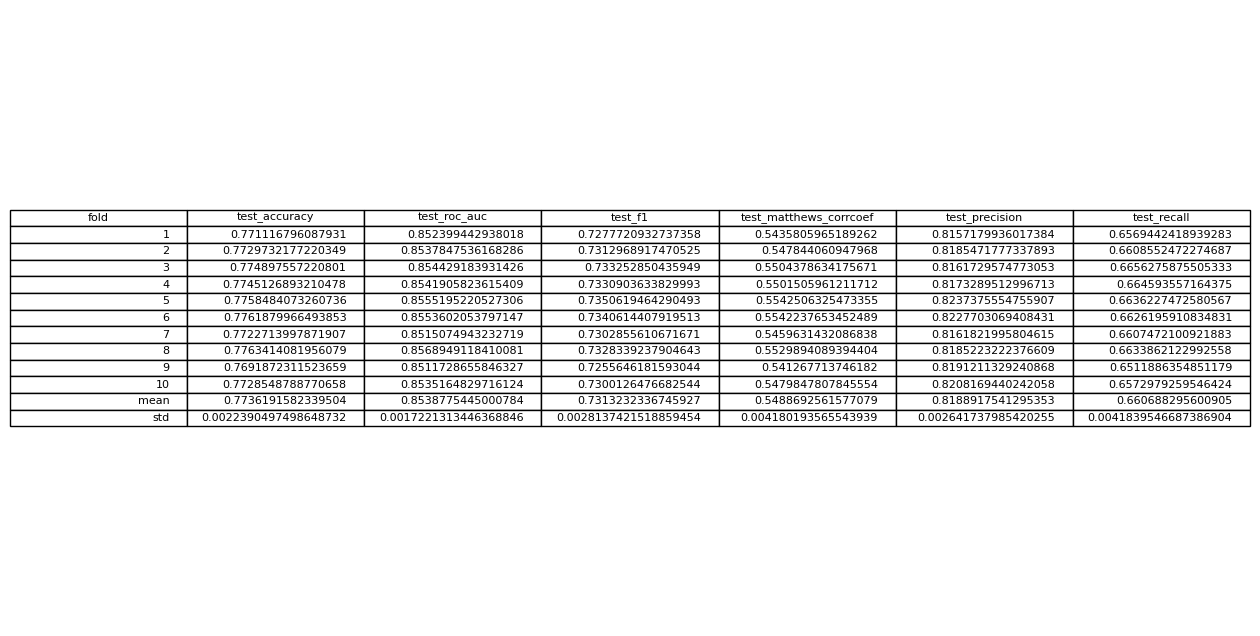

In [9]:
INPUT_FILE = "base_features.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1' : 'f1',
    'matthews_corrcoef': 'matthews_corrcoef',
    'precision': 'precision',
    'recall': 'recall'
}

scores = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop(columns=['fit_time', 'score_time'])
mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

train_scores = scores_df[['fold', 'train_accuracy', 'train_roc_auc', 'train_f1', 'train_matthews_corrcoef', 'train_precision', 'train_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = train_scores.values, colLabels = train_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"score_metrics_train_{INPUT_FILE.rstrip('.csv')}.png")

test_scores = scores_df[['fold', 'test_accuracy', 'test_roc_auc', 'test_f1', 'test_matthews_corrcoef', 'test_precision', 'test_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = test_scores.values, colLabels = test_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"lr_score_metrics_test_{INPUT_FILE.rstrip('.csv')}.png")

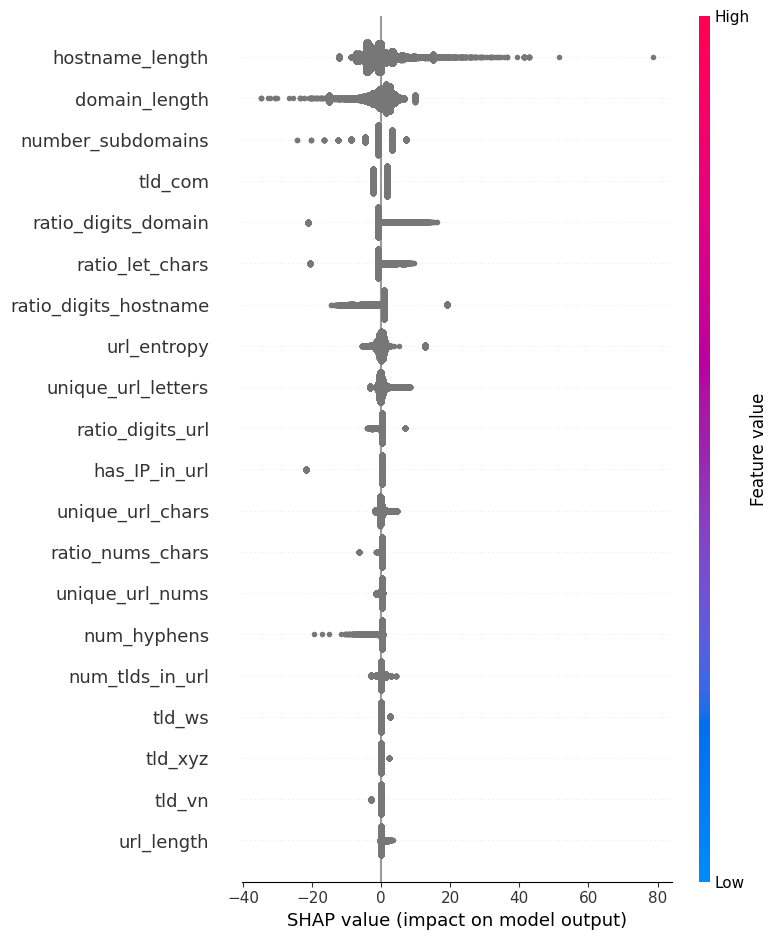

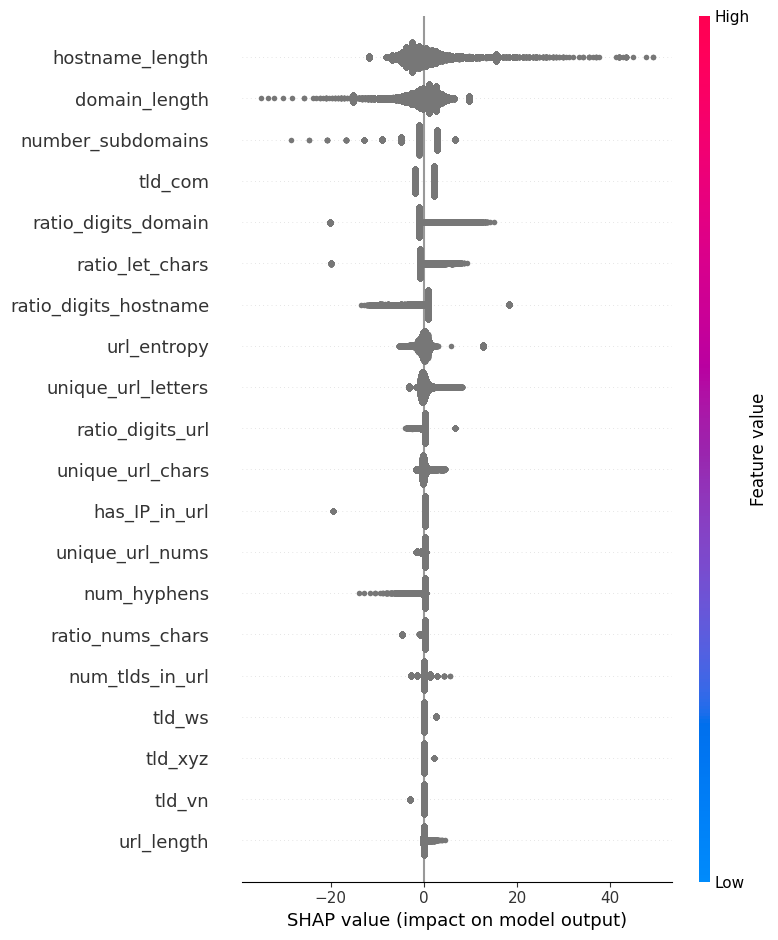

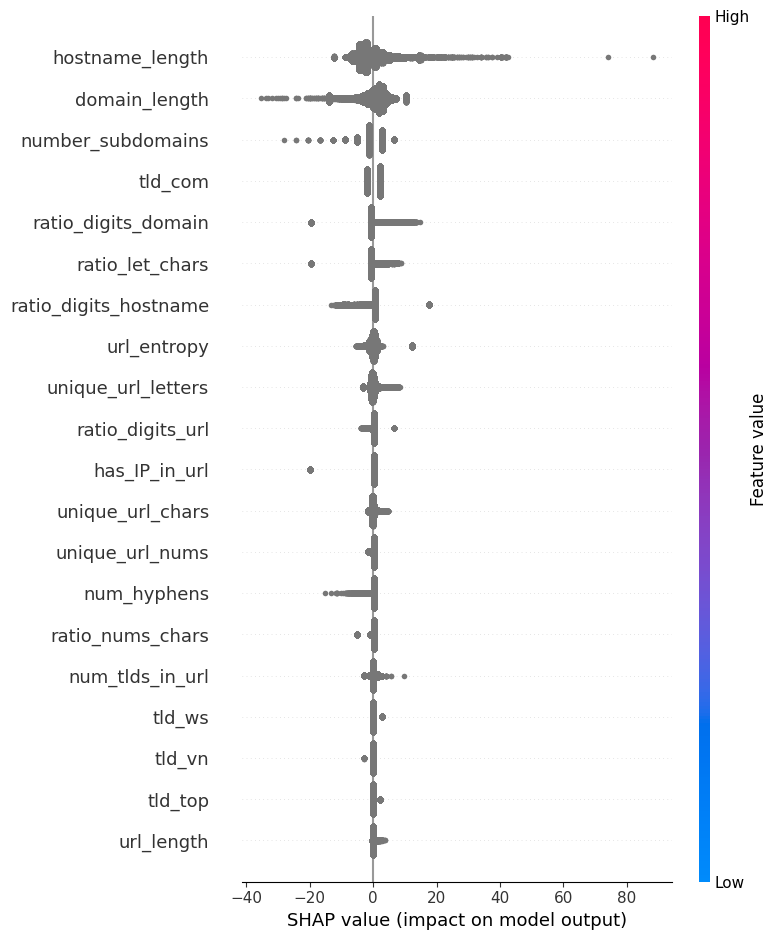

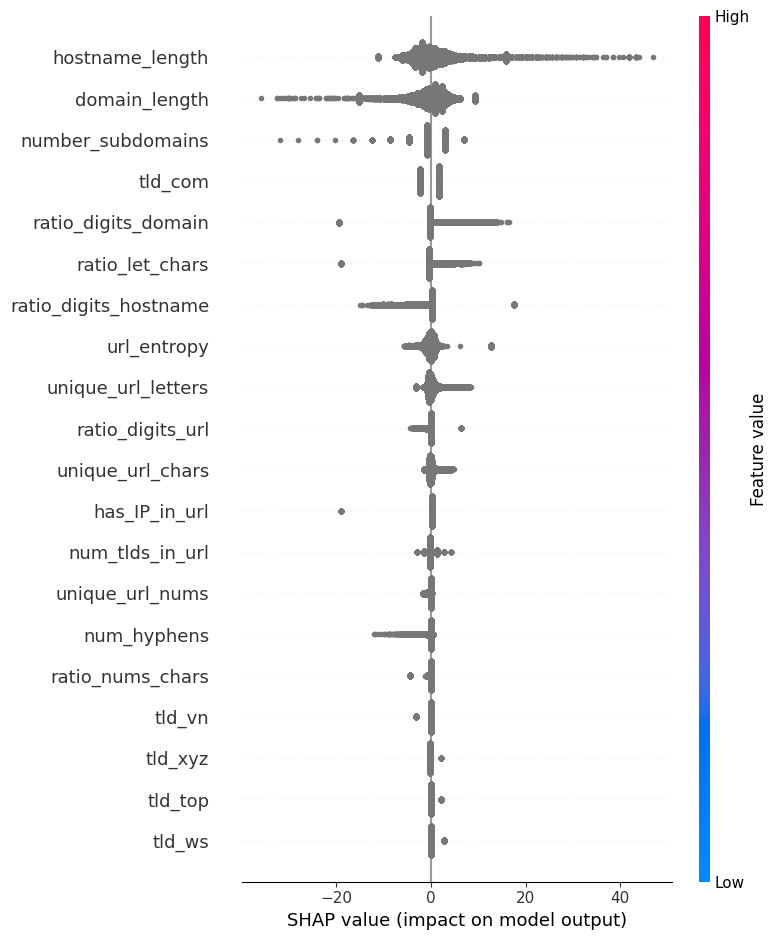

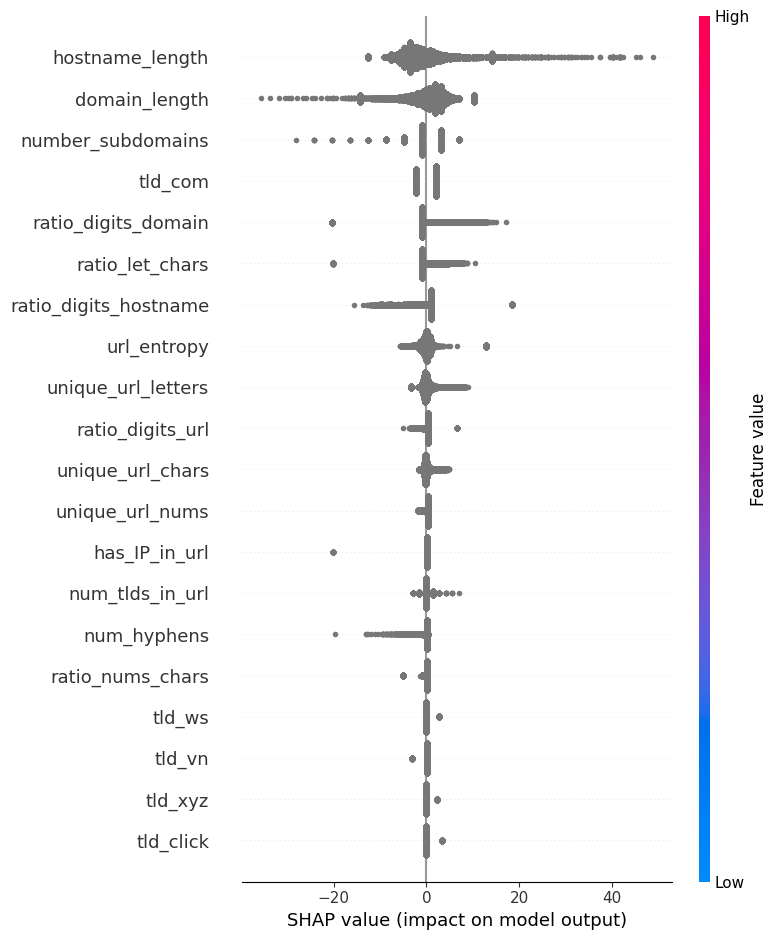

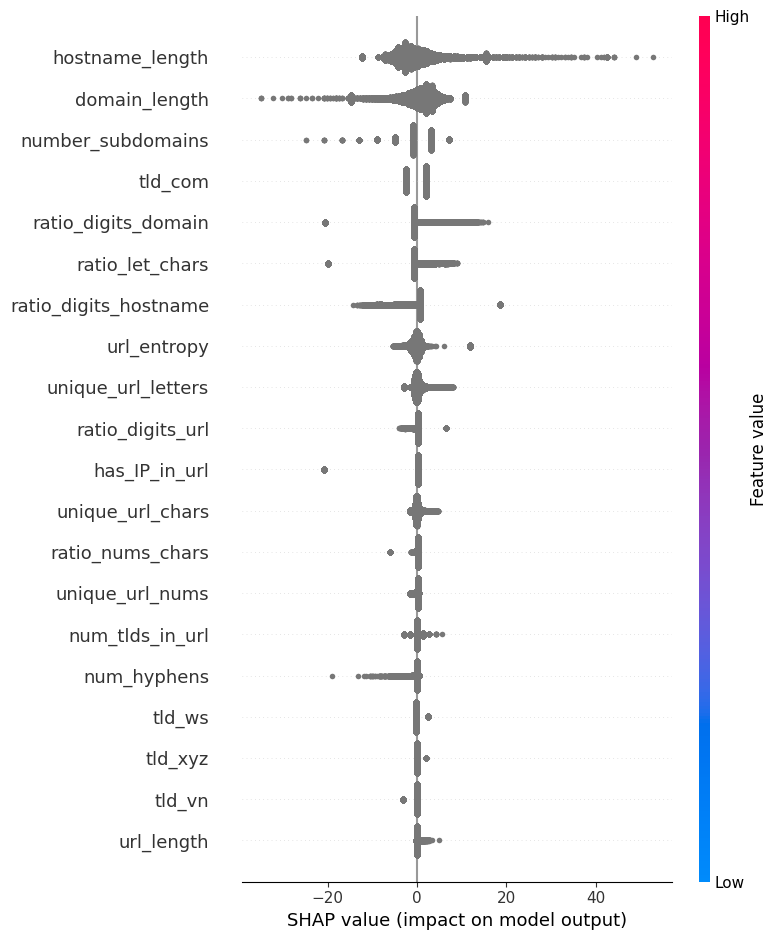

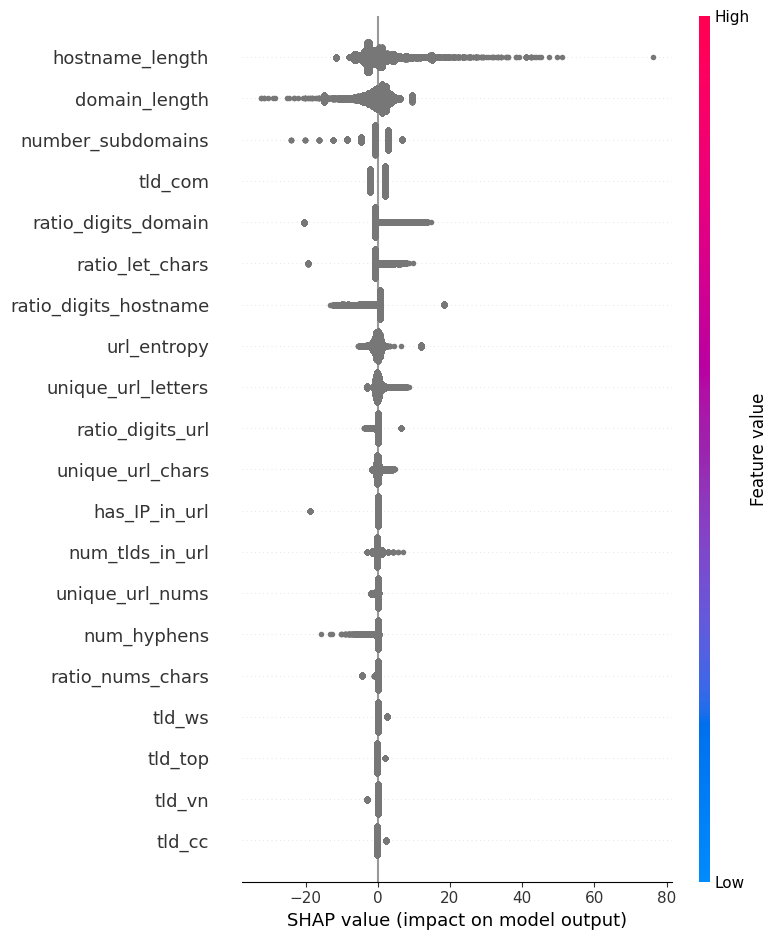

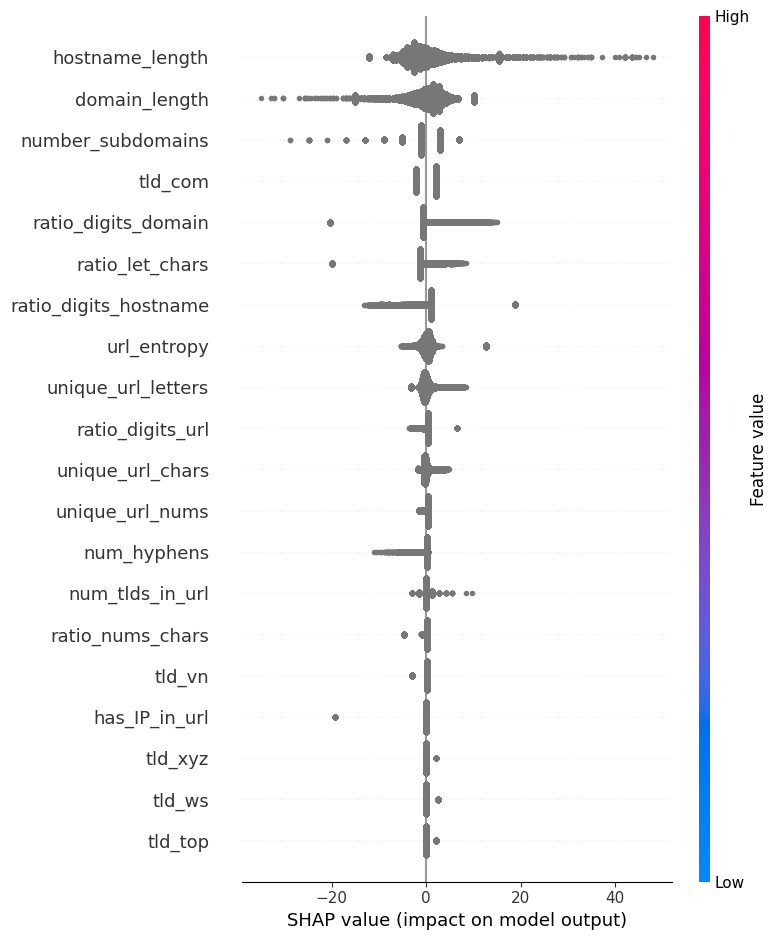

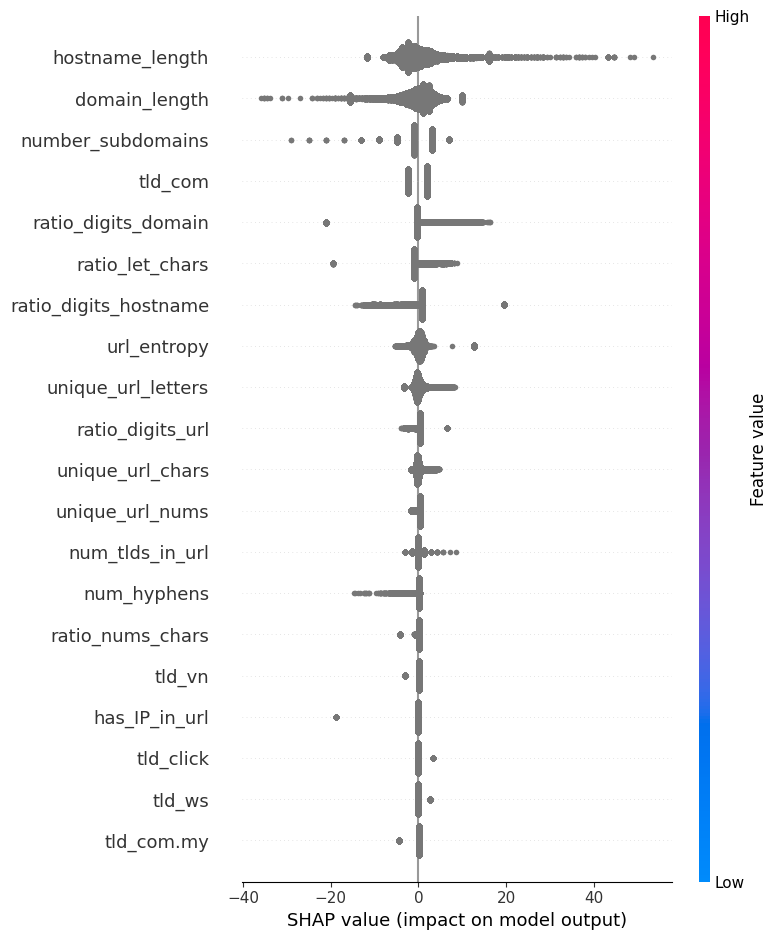

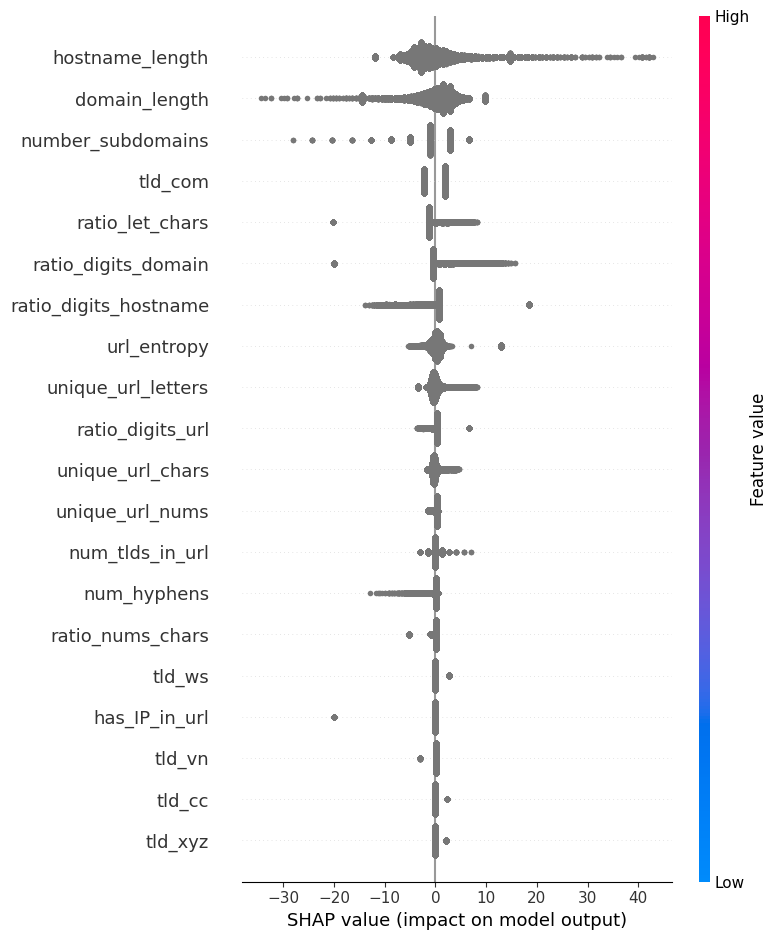

In [20]:
INPUT_FILE = "base_features.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict(X_test)

    explainer = shap.Explainer(lr, X_train, feature_names=features)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)

## Cascade 1

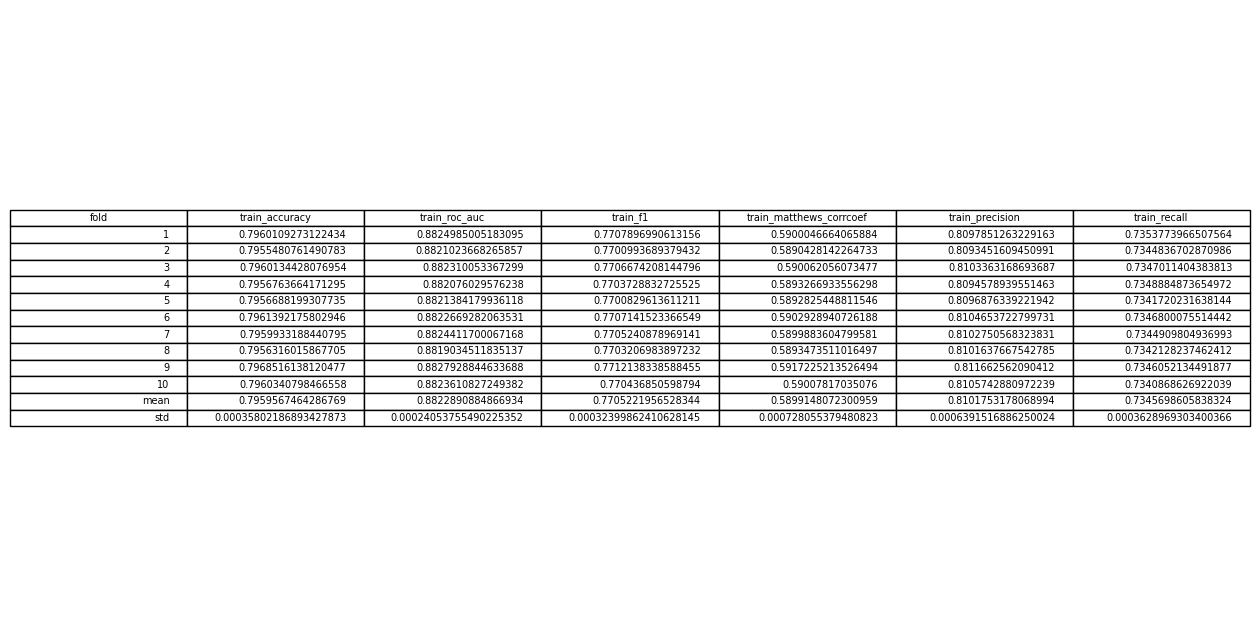

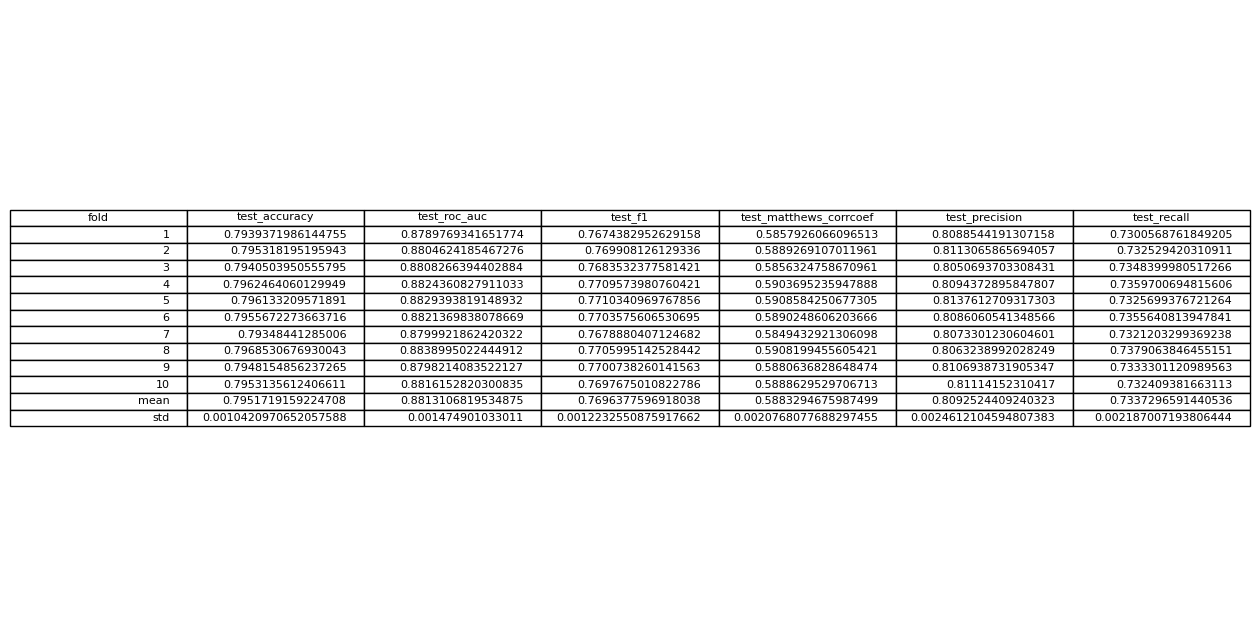

In [21]:
INPUT_FILE = "cascade_1.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1' : 'f1',
    'matthews_corrcoef': 'matthews_corrcoef',
    'precision': 'precision',
    'recall': 'recall'
}

scores = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop(columns=['fit_time', 'score_time'])
mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

train_scores = scores_df[['fold', 'train_accuracy', 'train_roc_auc', 'train_f1', 'train_matthews_corrcoef', 'train_precision', 'train_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = train_scores.values, colLabels = train_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"score_metrics_train_{INPUT_FILE.rstrip('.csv')}.png")

test_scores = scores_df[['fold', 'test_accuracy', 'test_roc_auc', 'test_f1', 'test_matthews_corrcoef', 'test_precision', 'test_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = test_scores.values, colLabels = test_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"lr_score_metrics_test_{INPUT_FILE.rstrip('.csv')}.png")

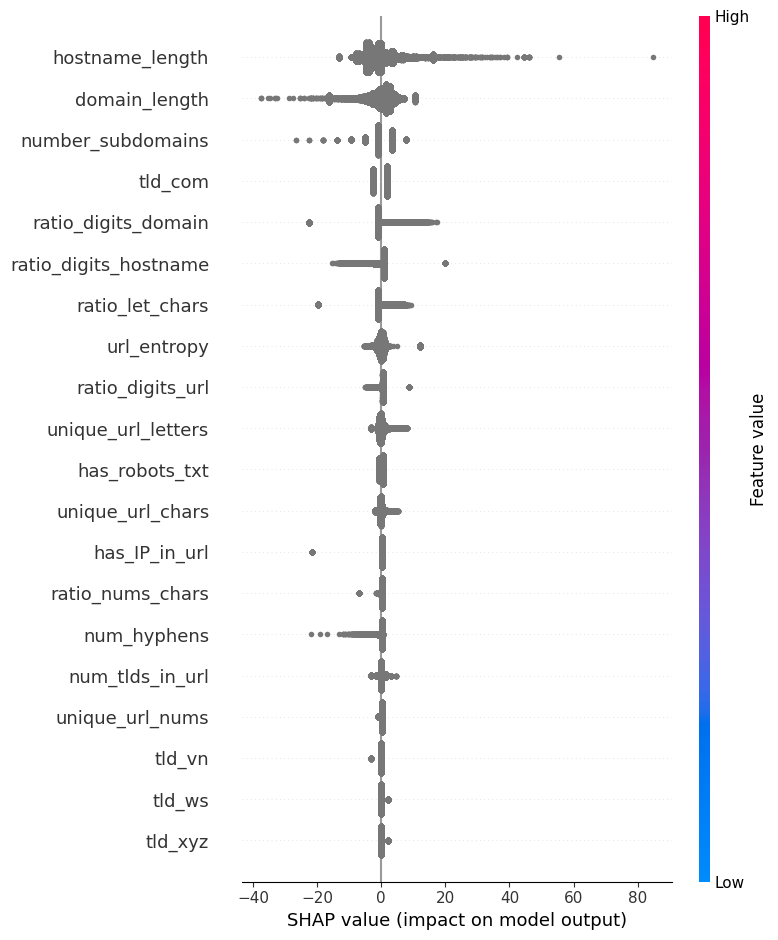

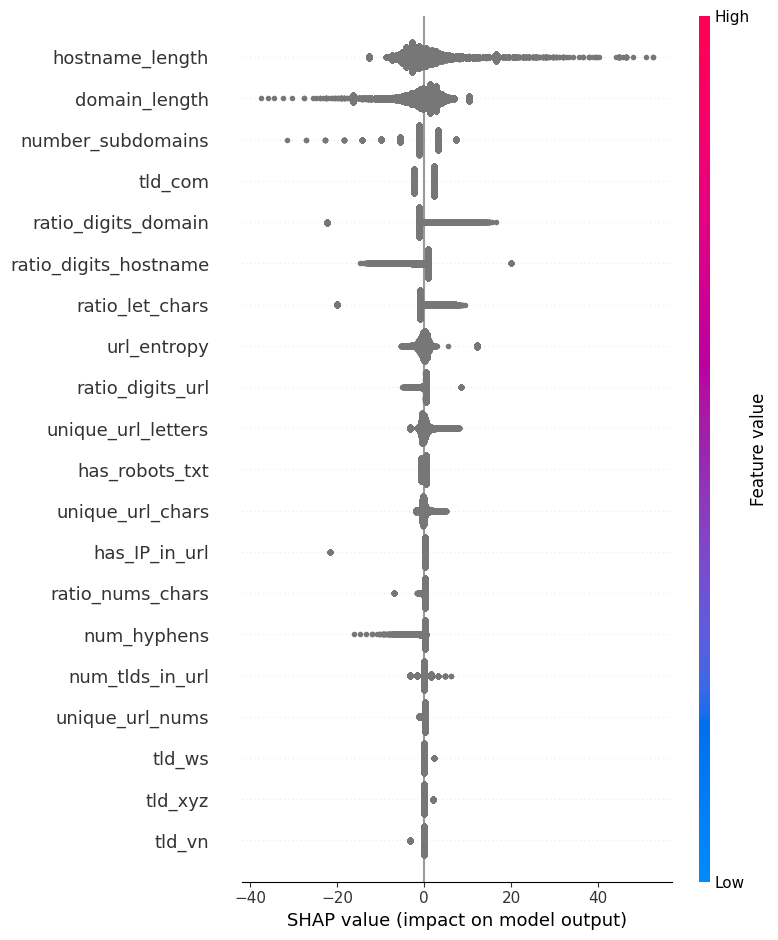

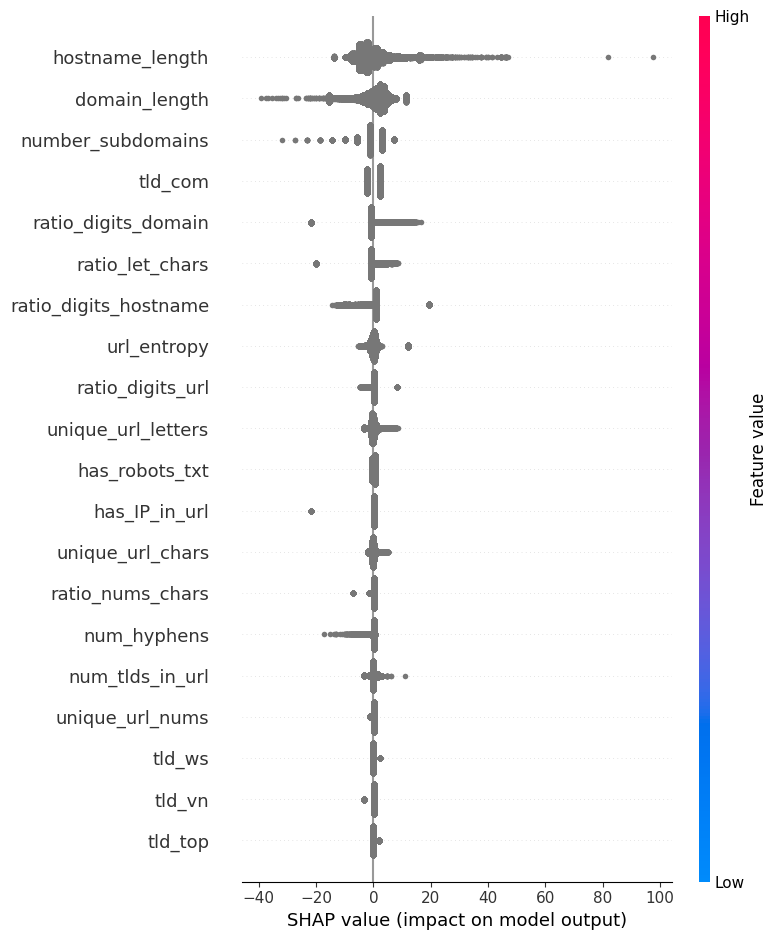

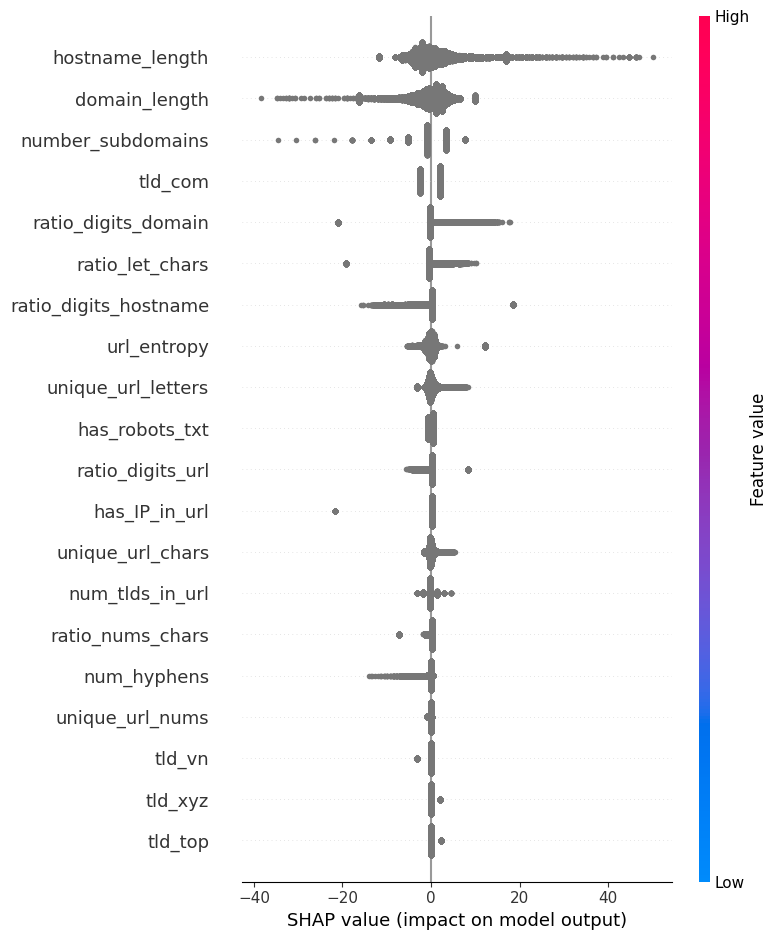

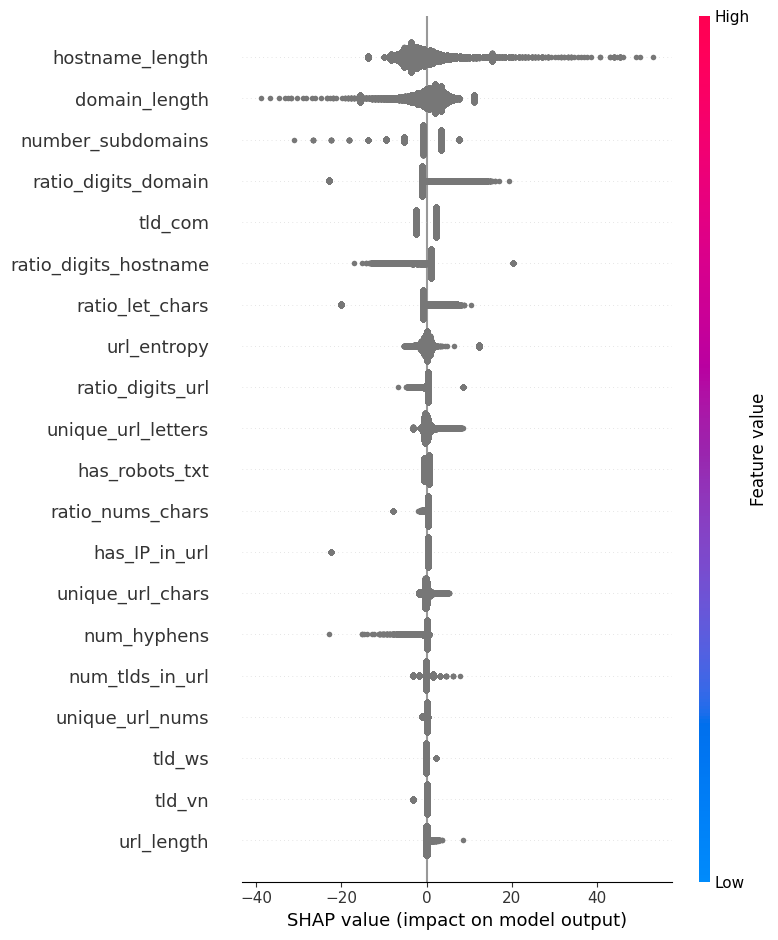

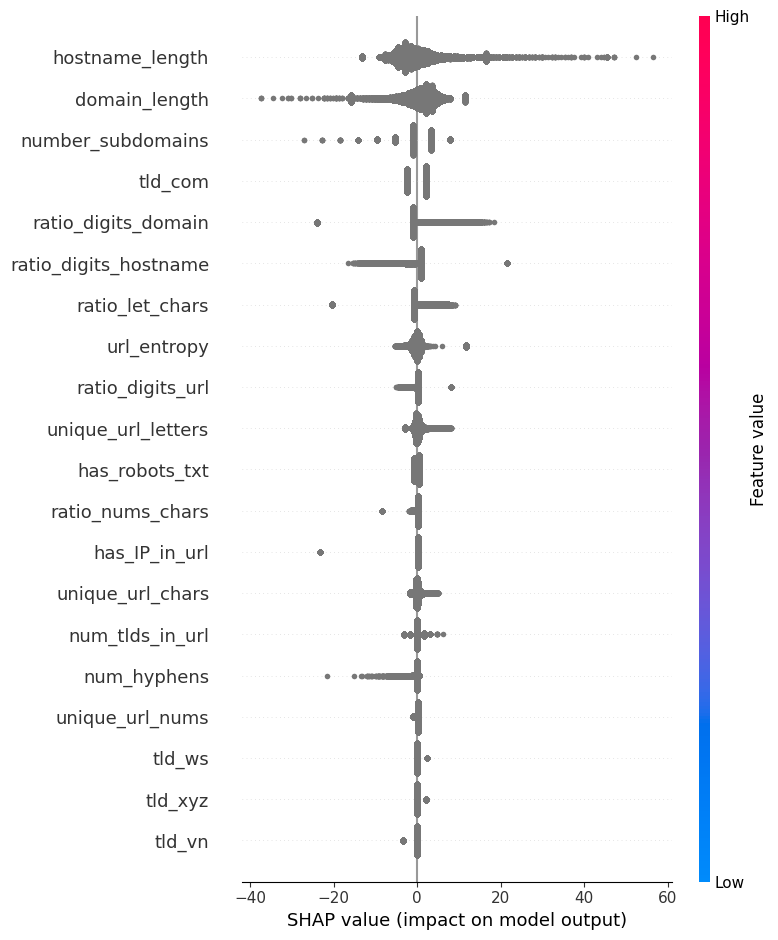

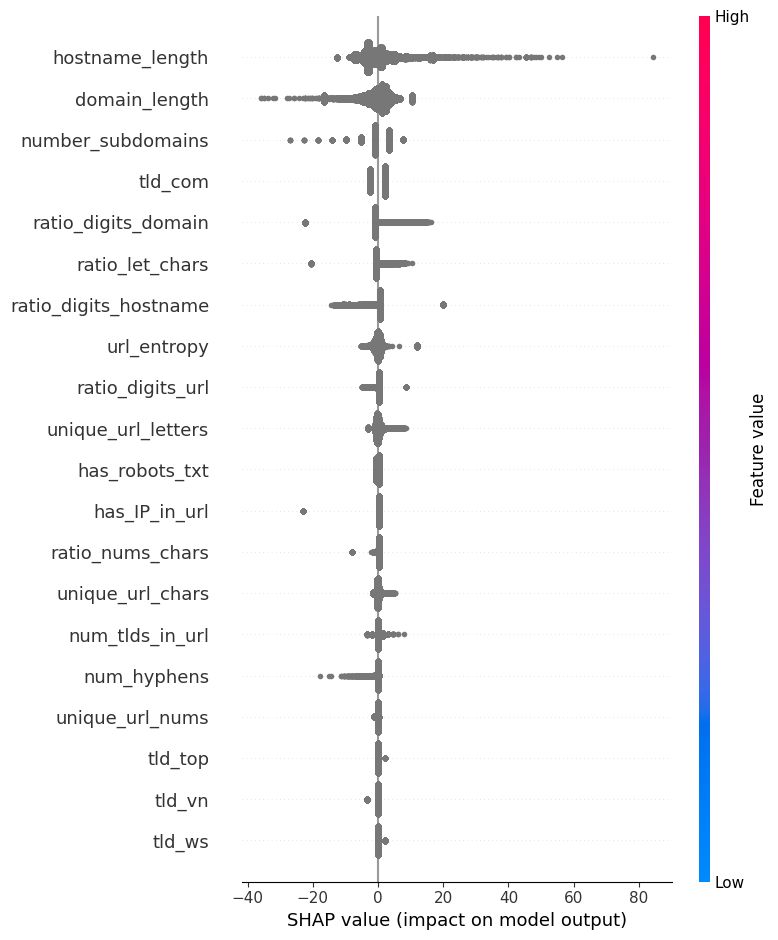

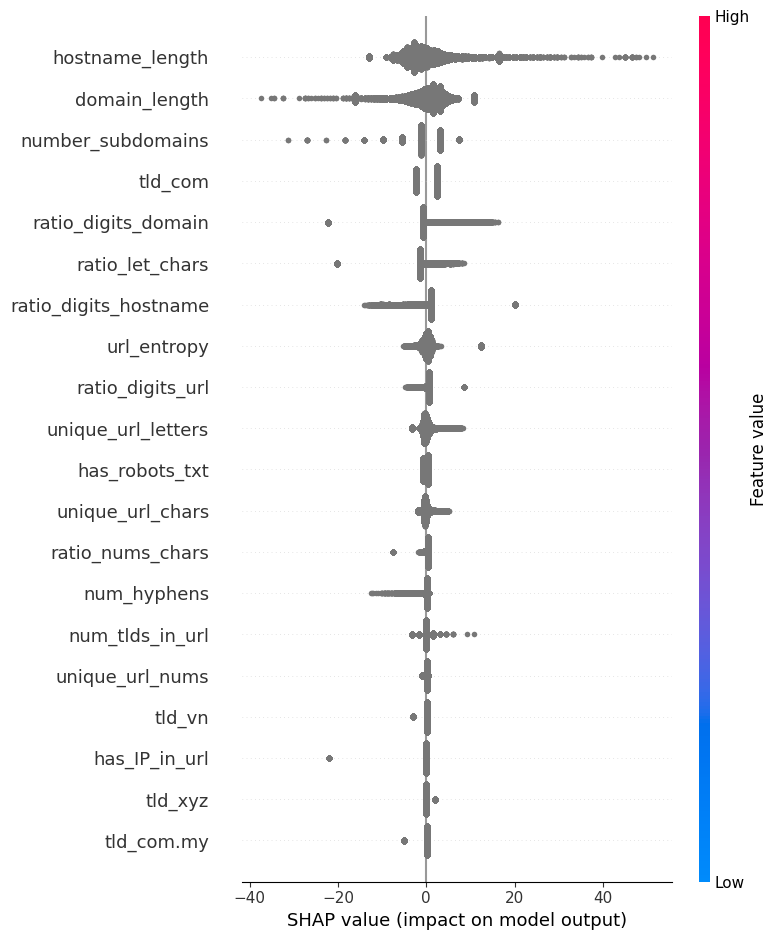

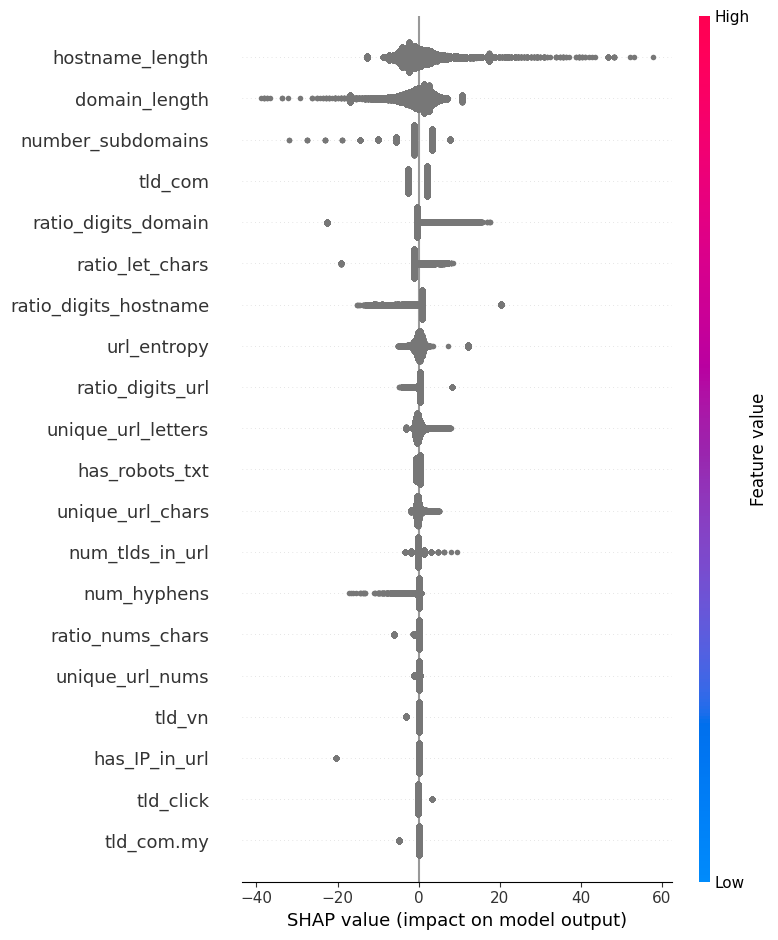

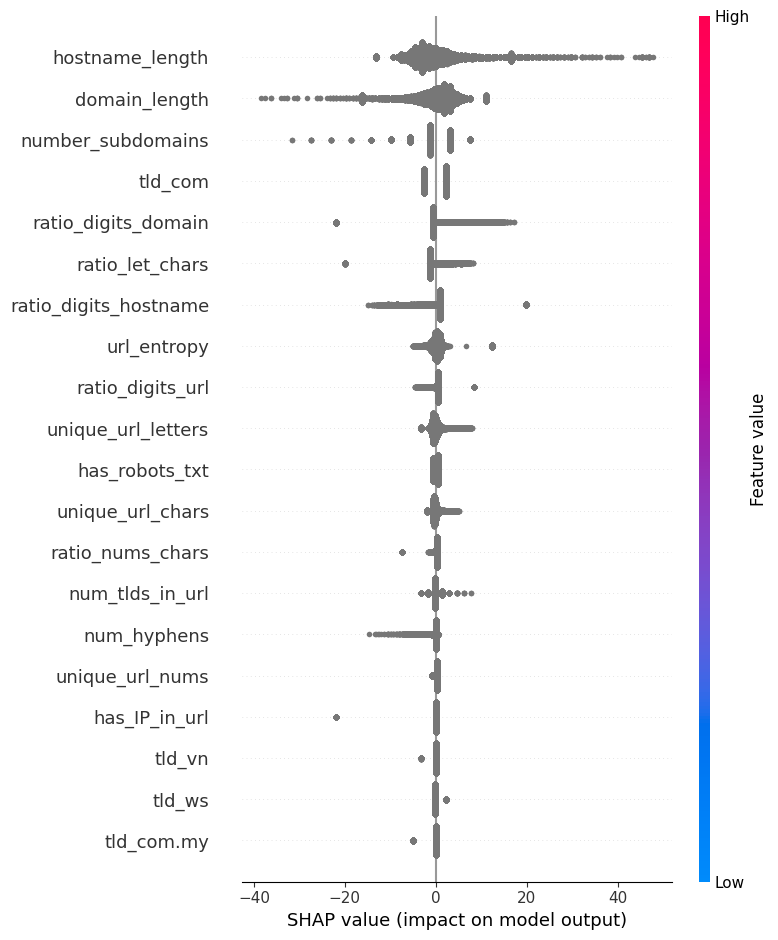

In [22]:
INPUT_FILE = "cascade_1.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict(X_test)

    explainer = shap.Explainer(lr, X_train, feature_names=features)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)

## Cascade 2

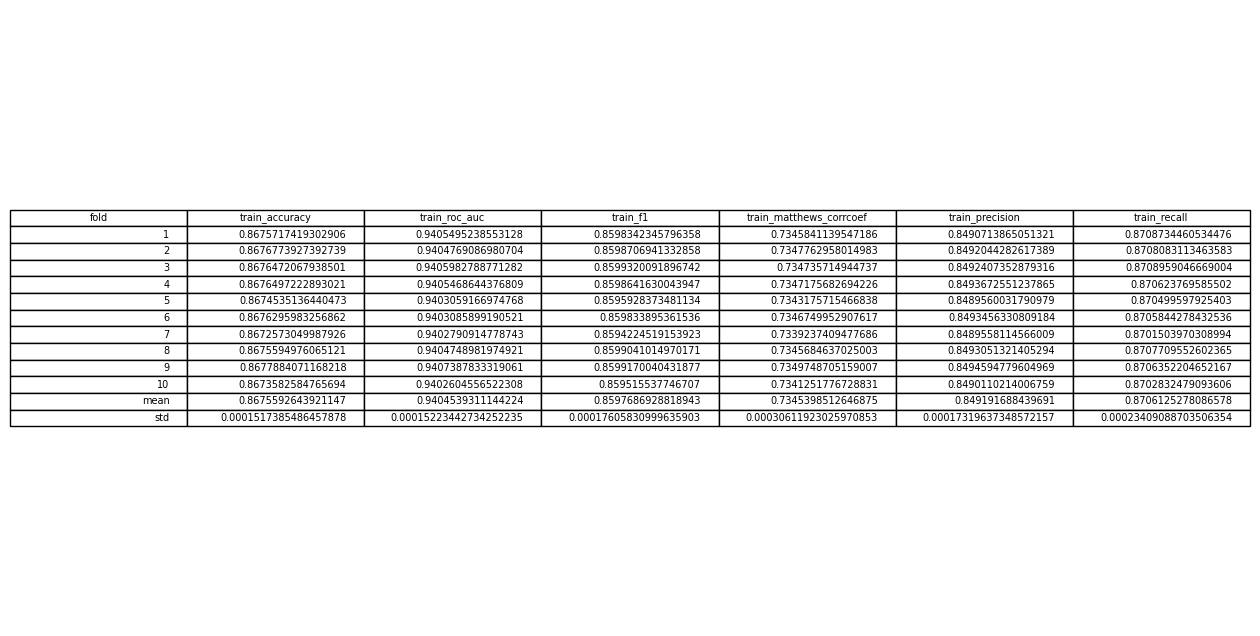

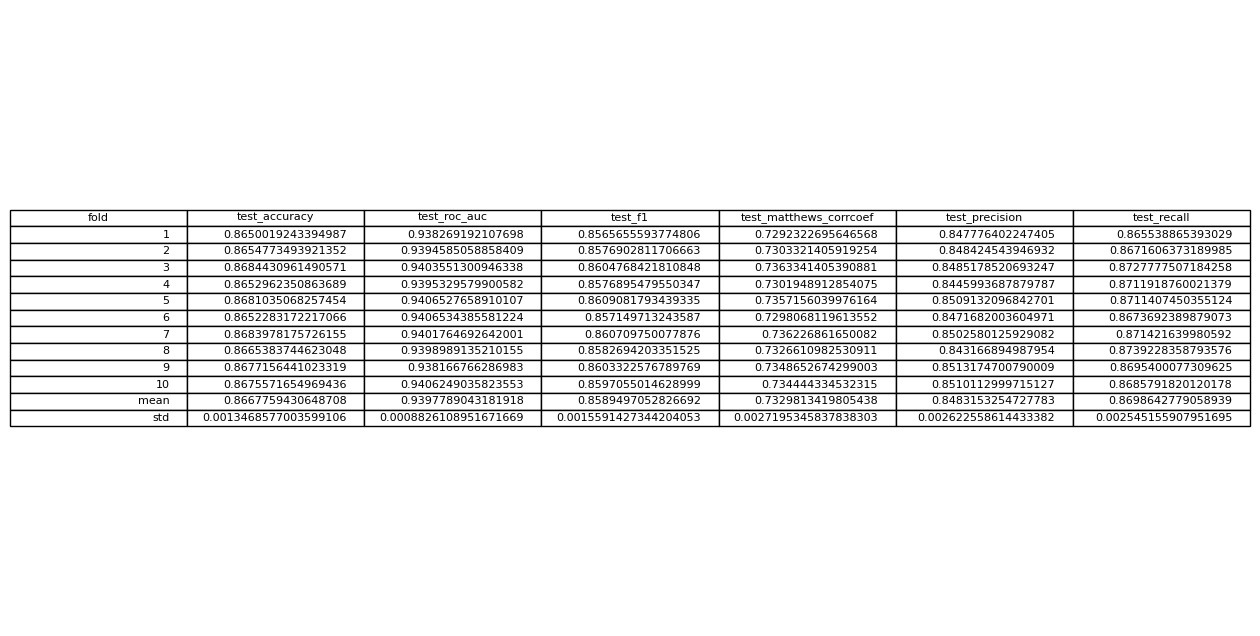

In [23]:
INPUT_FILE = "cascade_2.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1' : 'f1',
    'matthews_corrcoef': 'matthews_corrcoef',
    'precision': 'precision',
    'recall': 'recall'
}

scores = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop(columns=['fit_time', 'score_time'])
mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

train_scores = scores_df[['fold', 'train_accuracy', 'train_roc_auc', 'train_f1', 'train_matthews_corrcoef', 'train_precision', 'train_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = train_scores.values, colLabels = train_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"score_metrics_train_{INPUT_FILE.rstrip('.csv')}.png")

test_scores = scores_df[['fold', 'test_accuracy', 'test_roc_auc', 'test_f1', 'test_matthews_corrcoef', 'test_precision', 'test_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = test_scores.values, colLabels = test_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"lr_score_metrics_test_{INPUT_FILE.rstrip('.csv')}.png")

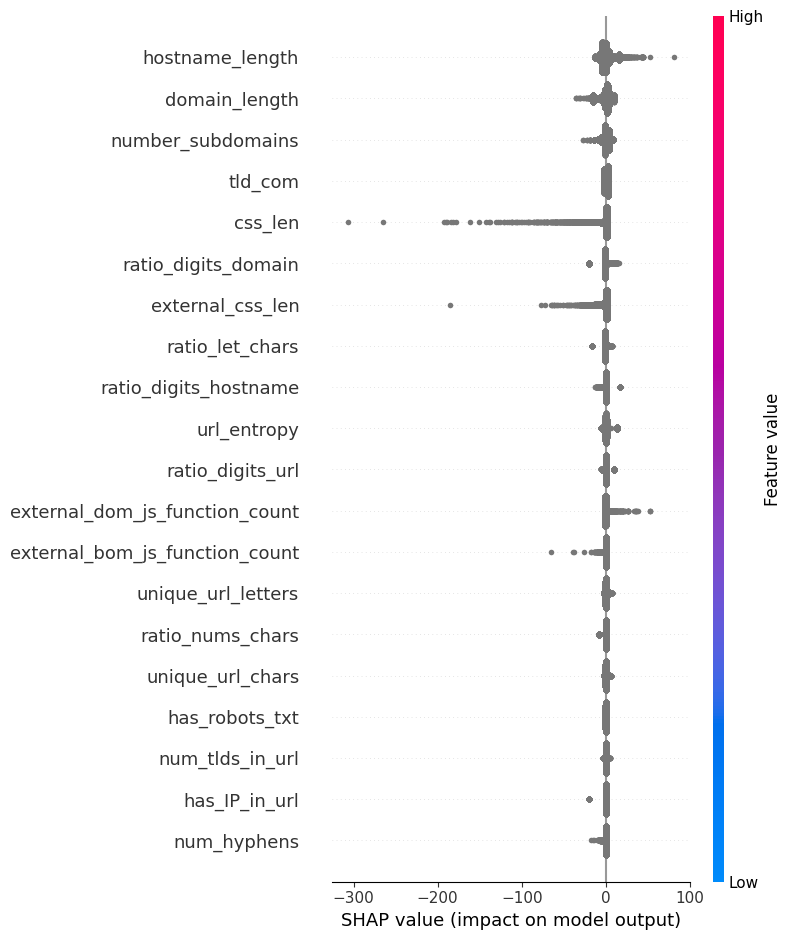

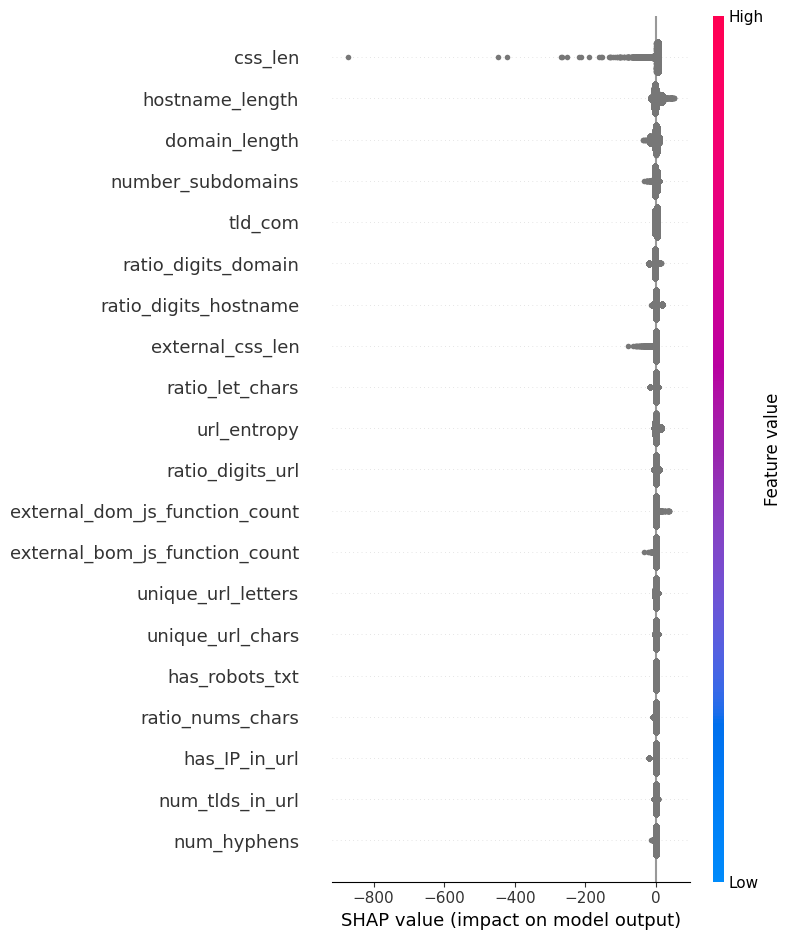

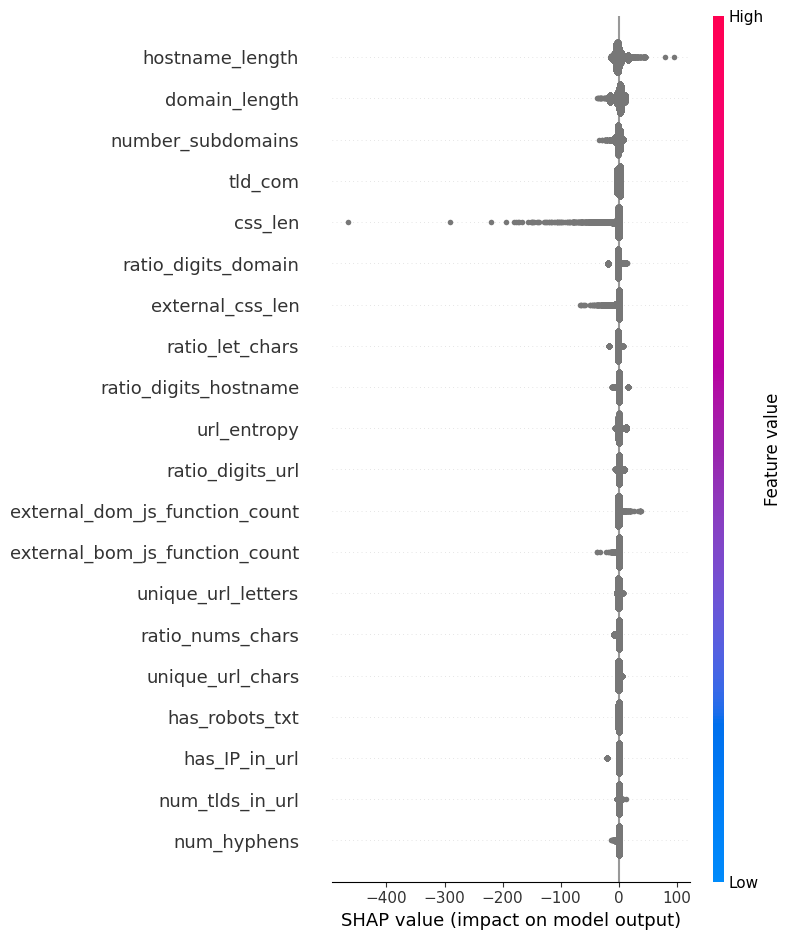

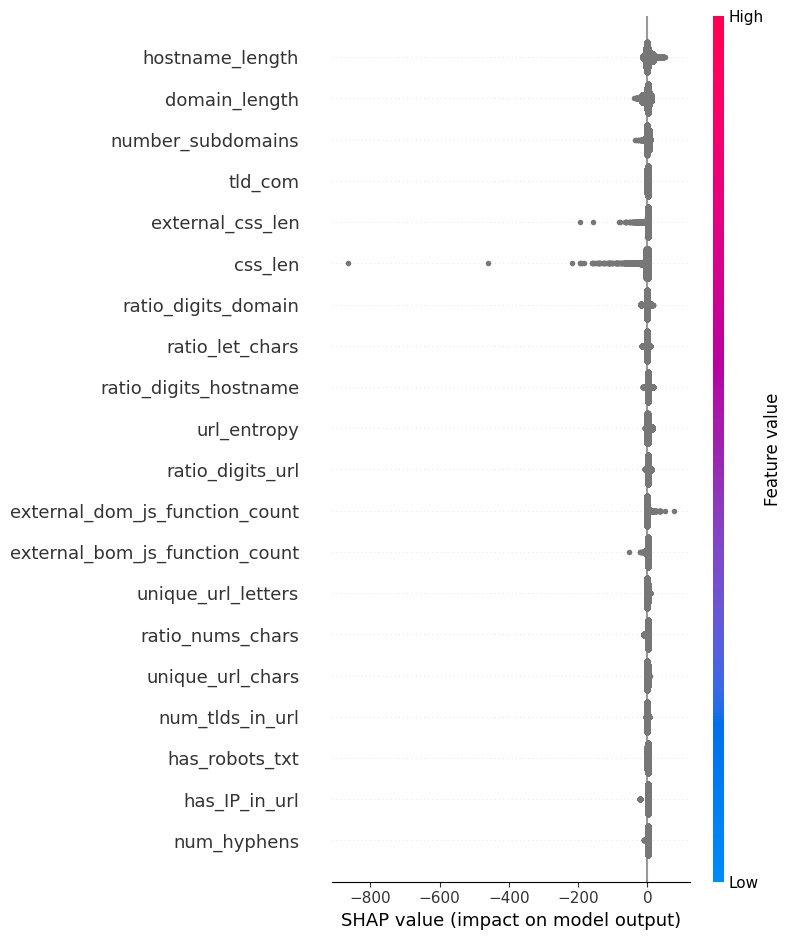

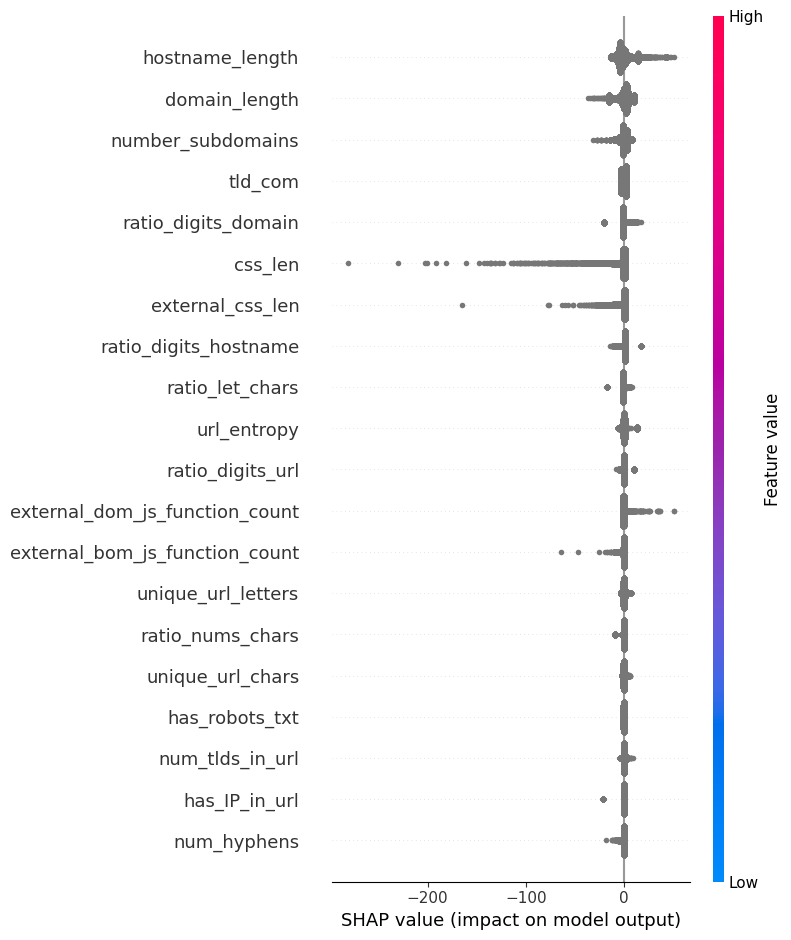

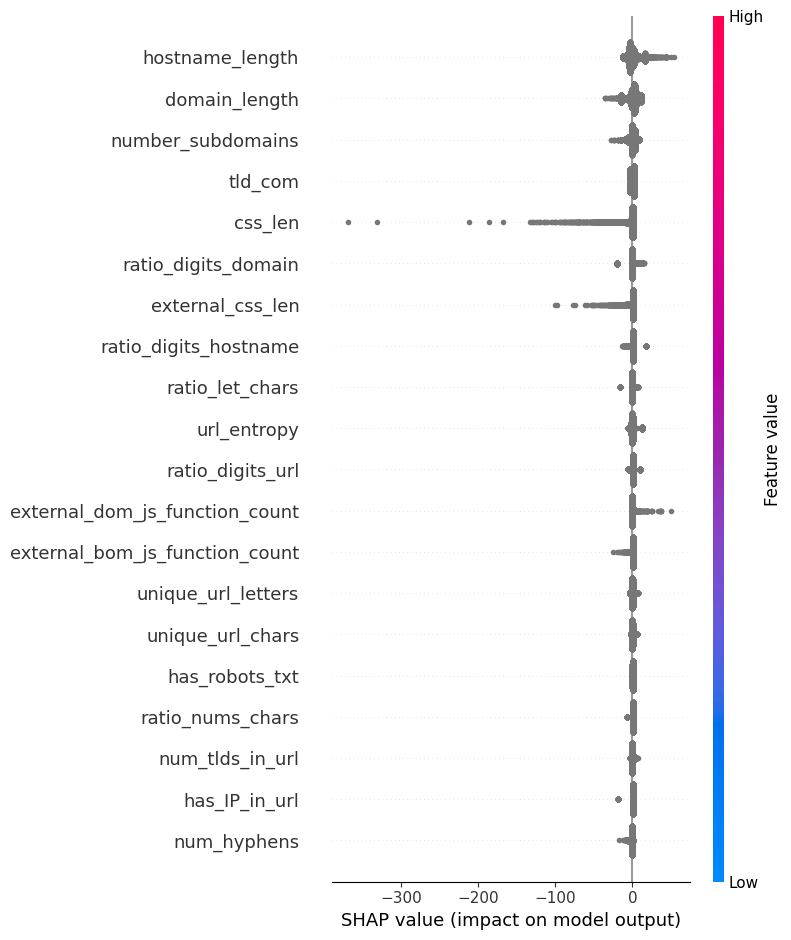

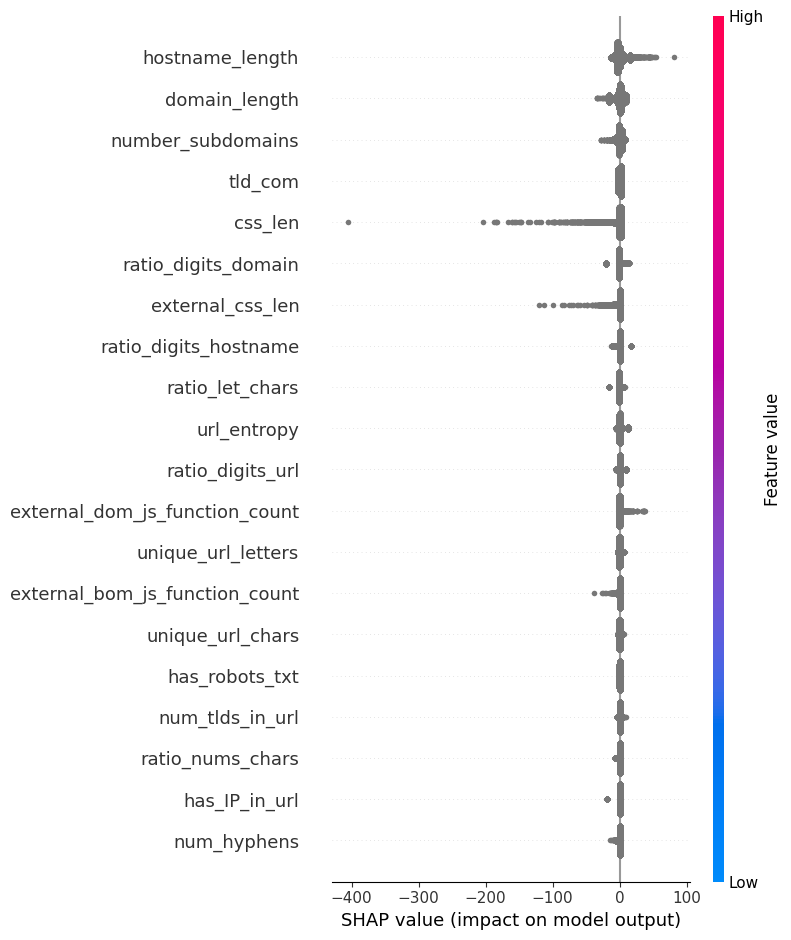

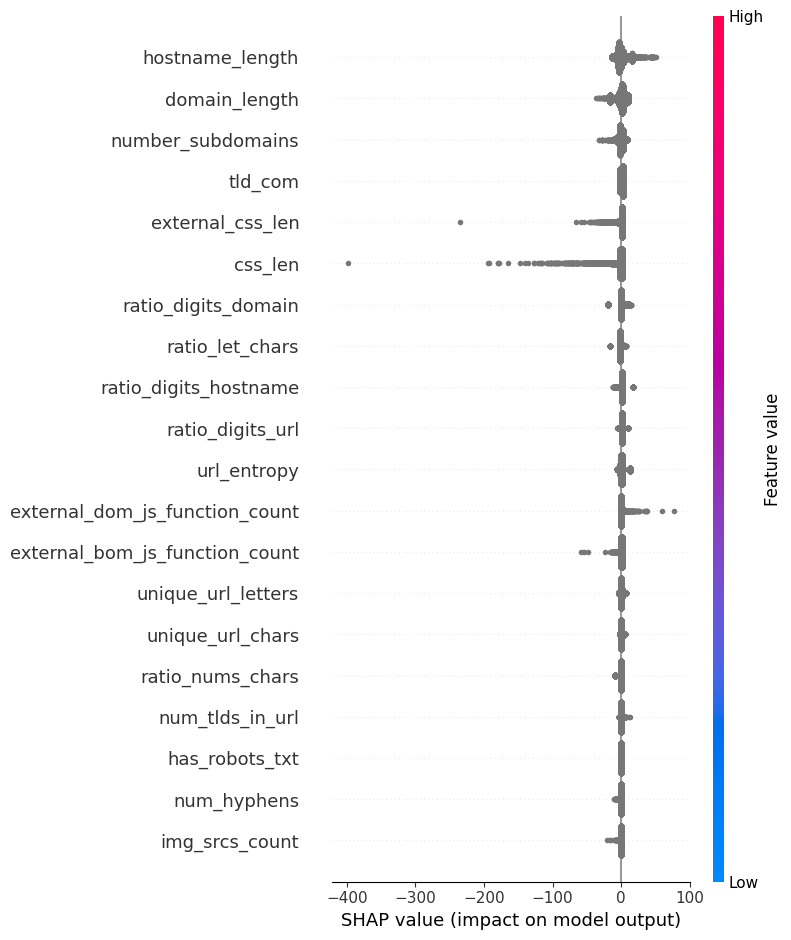

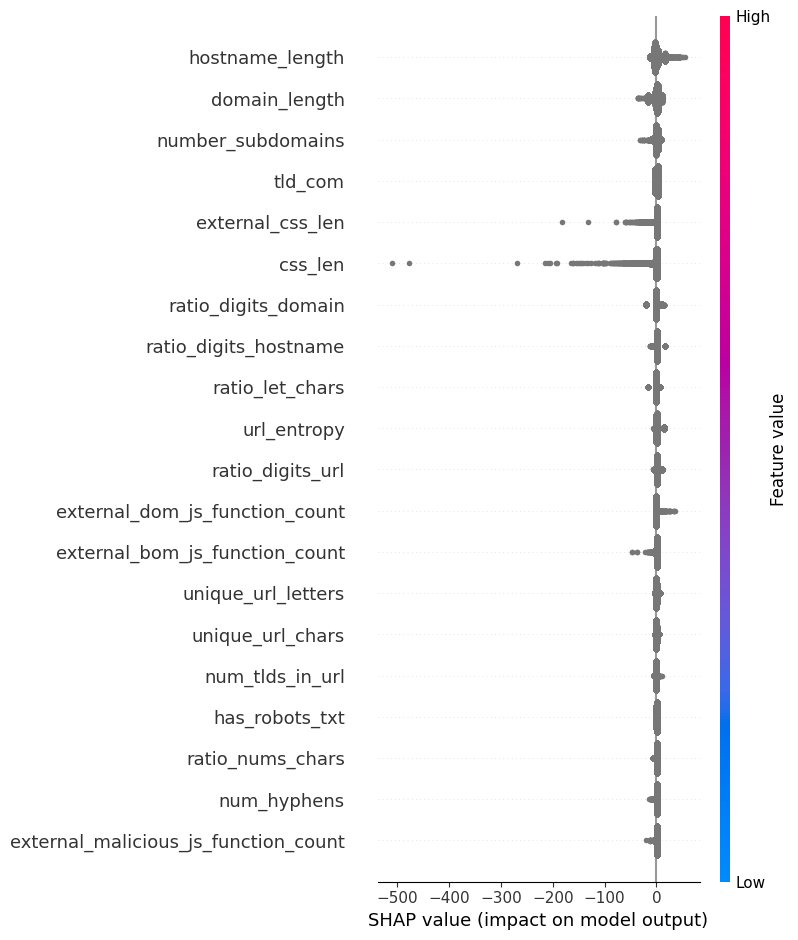

/home/sagemaker-user/rl_test/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


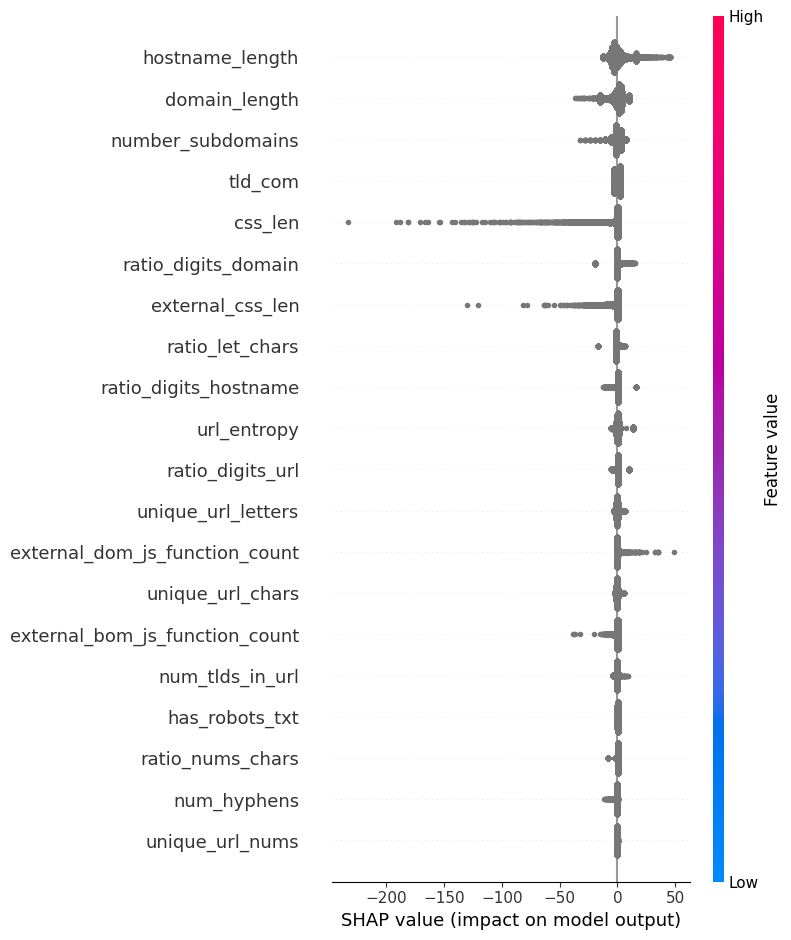

In [24]:
INPUT_FILE = "cascade_2.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict(X_test)

    explainer = shap.Explainer(lr, X_train, feature_names=features)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)

## Cascade 3

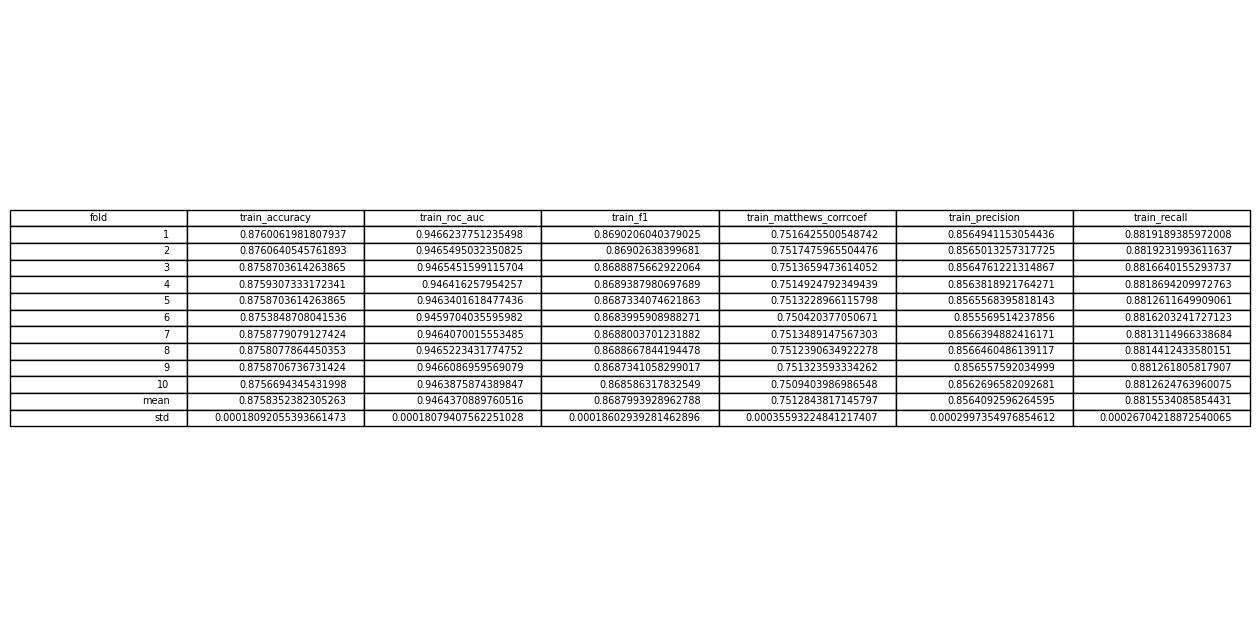

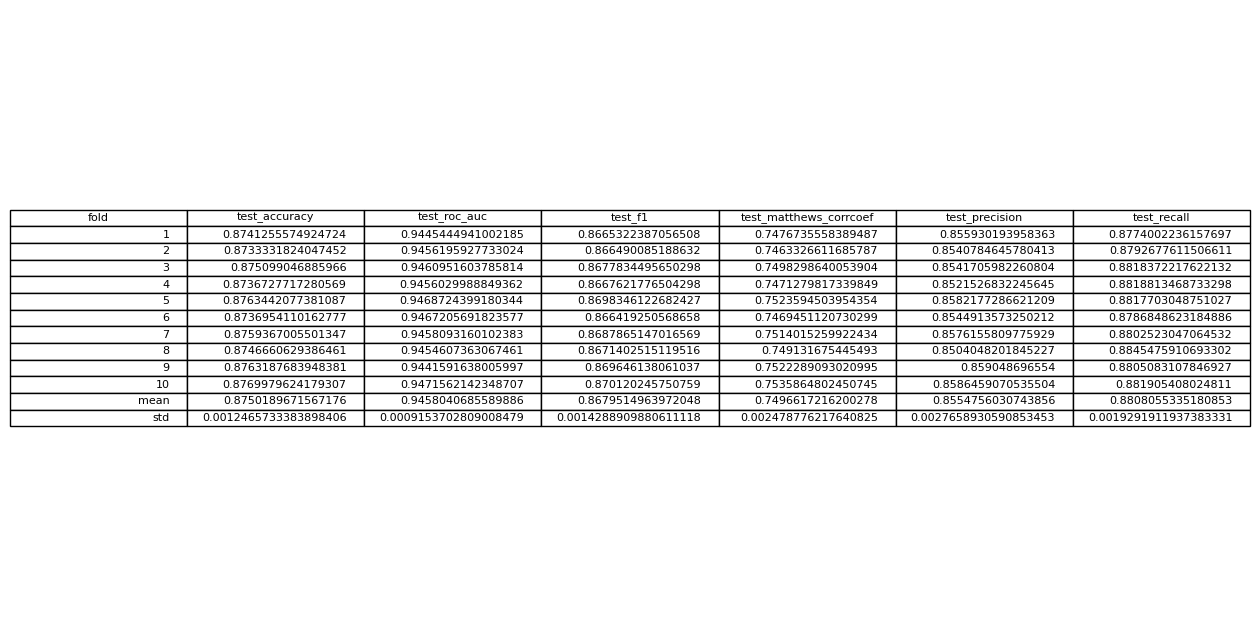

In [25]:
INPUT_FILE = "cascade_3.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1' : 'f1',
    'matthews_corrcoef': 'matthews_corrcoef',
    'precision': 'precision',
    'recall': 'recall'
}

scores = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop(columns=['fit_time', 'score_time'])
mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

train_scores = scores_df[['fold', 'train_accuracy', 'train_roc_auc', 'train_f1', 'train_matthews_corrcoef', 'train_precision', 'train_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = train_scores.values, colLabels = train_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"score_metrics_train_{INPUT_FILE.rstrip('.csv')}.png")

test_scores = scores_df[['fold', 'test_accuracy', 'test_roc_auc', 'test_f1', 'test_matthews_corrcoef', 'test_precision', 'test_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = test_scores.values, colLabels = test_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"lr_score_metrics_test_{INPUT_FILE.rstrip('.csv')}.png")

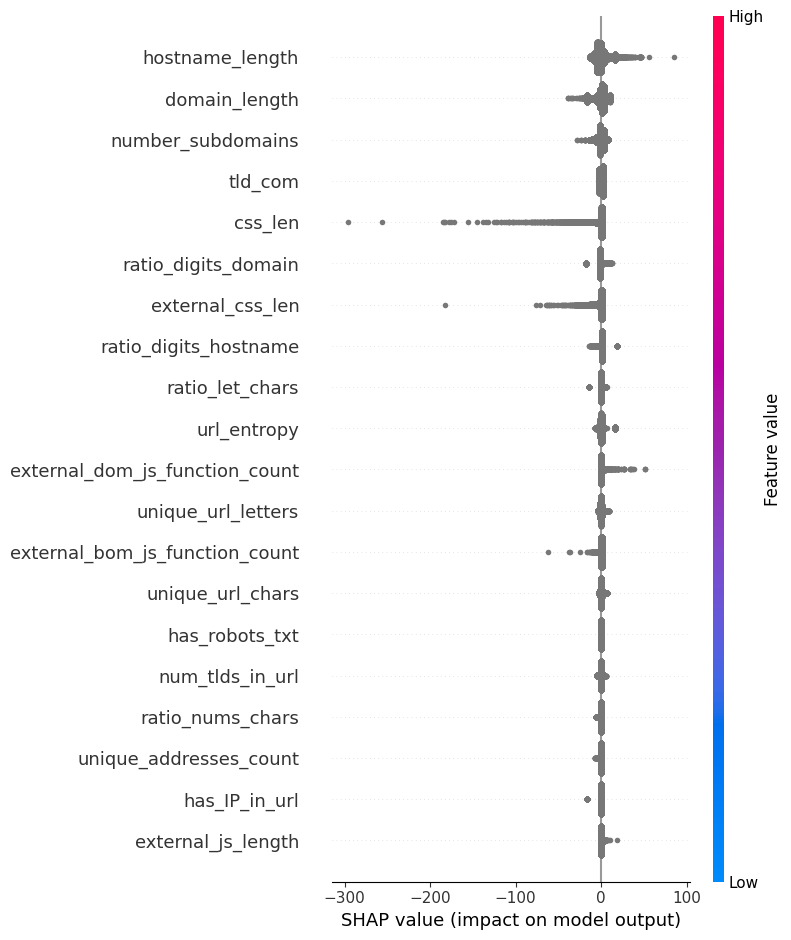

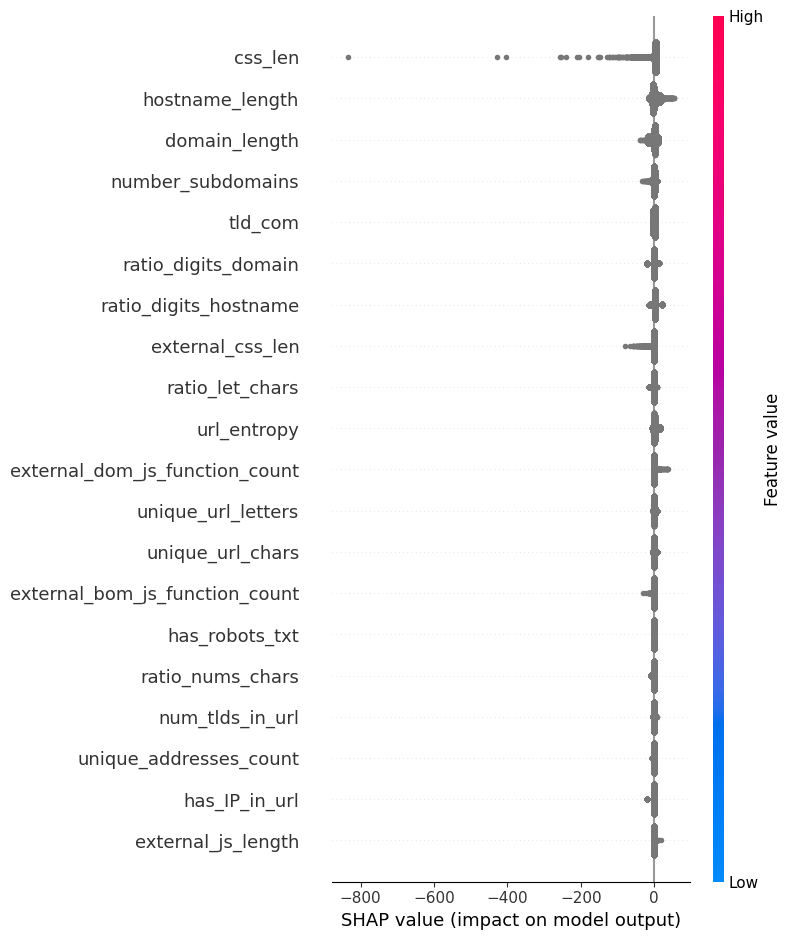

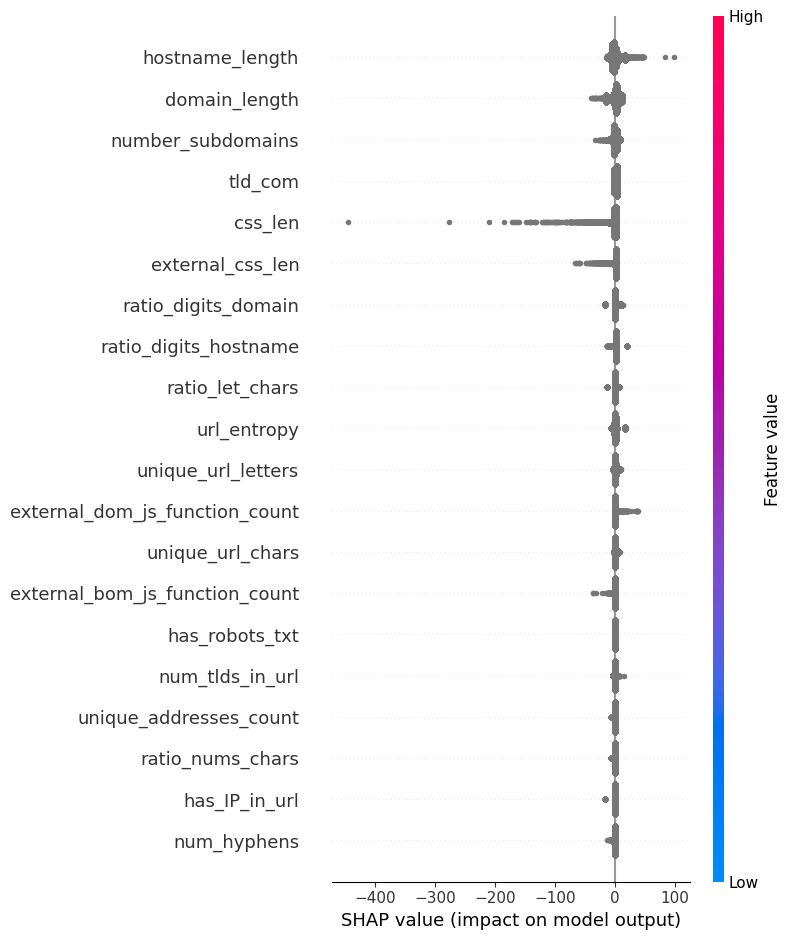

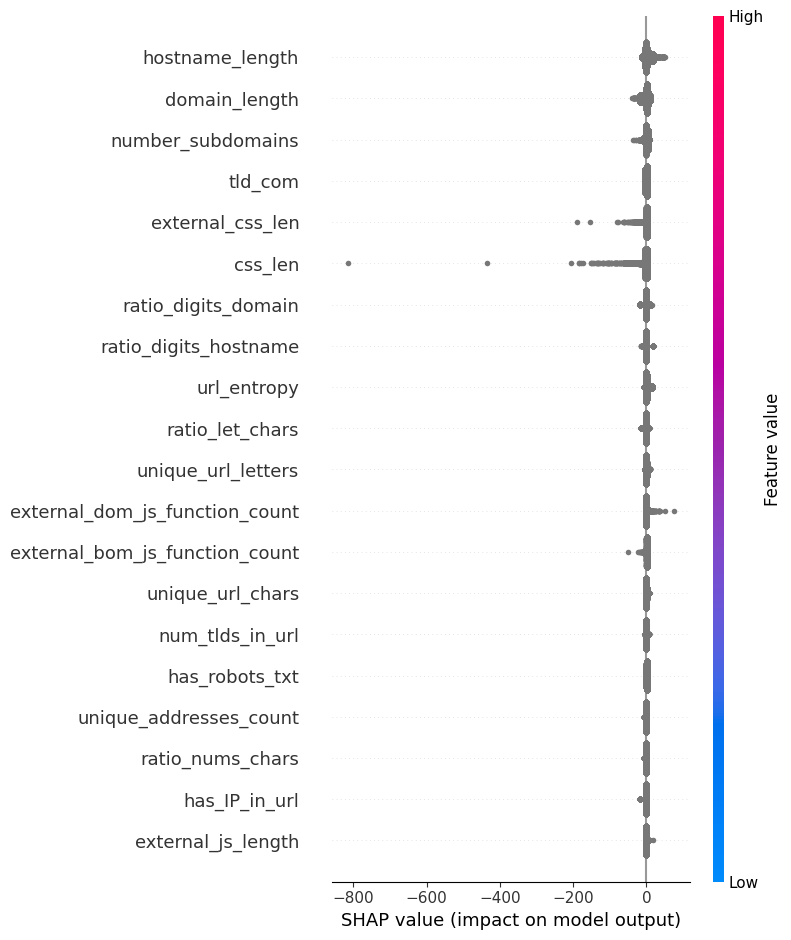

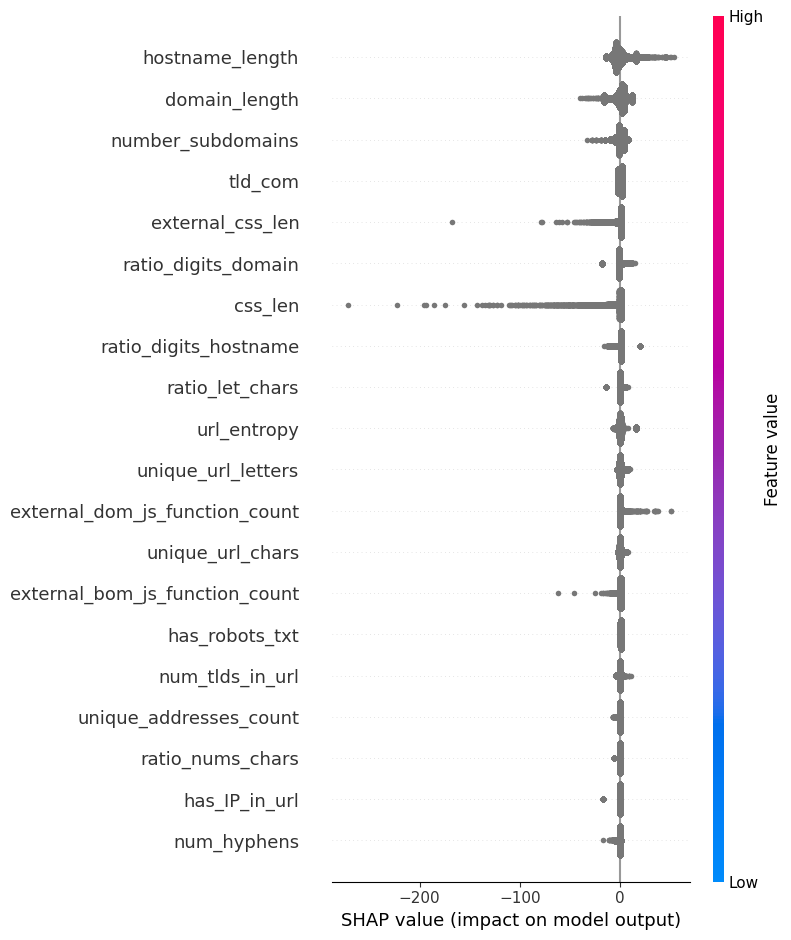

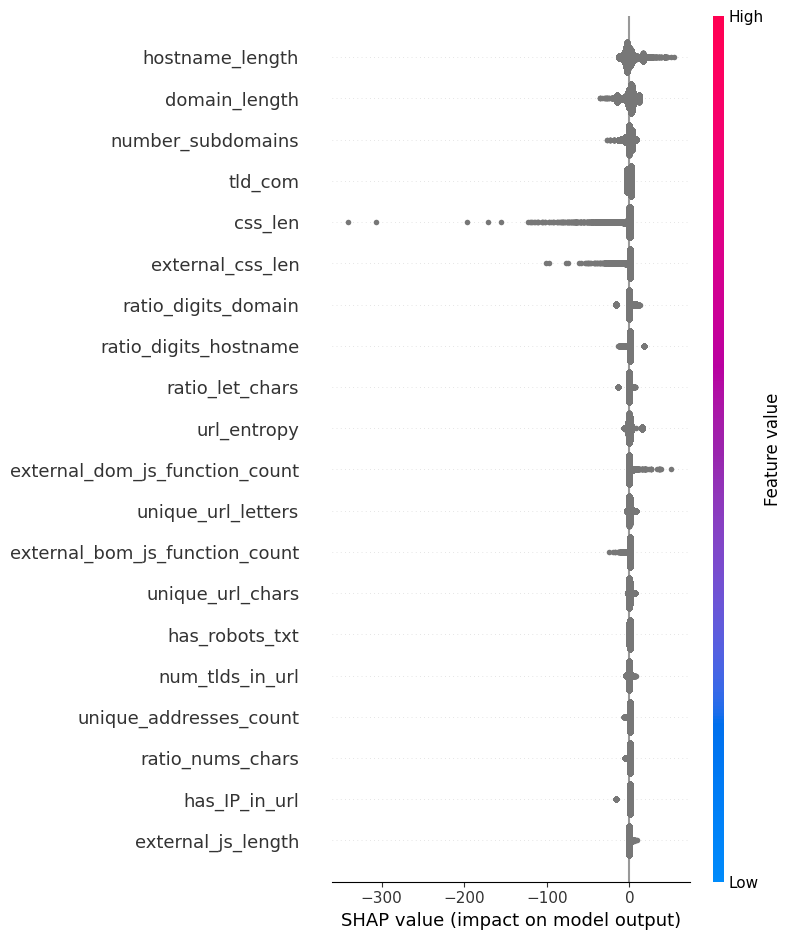

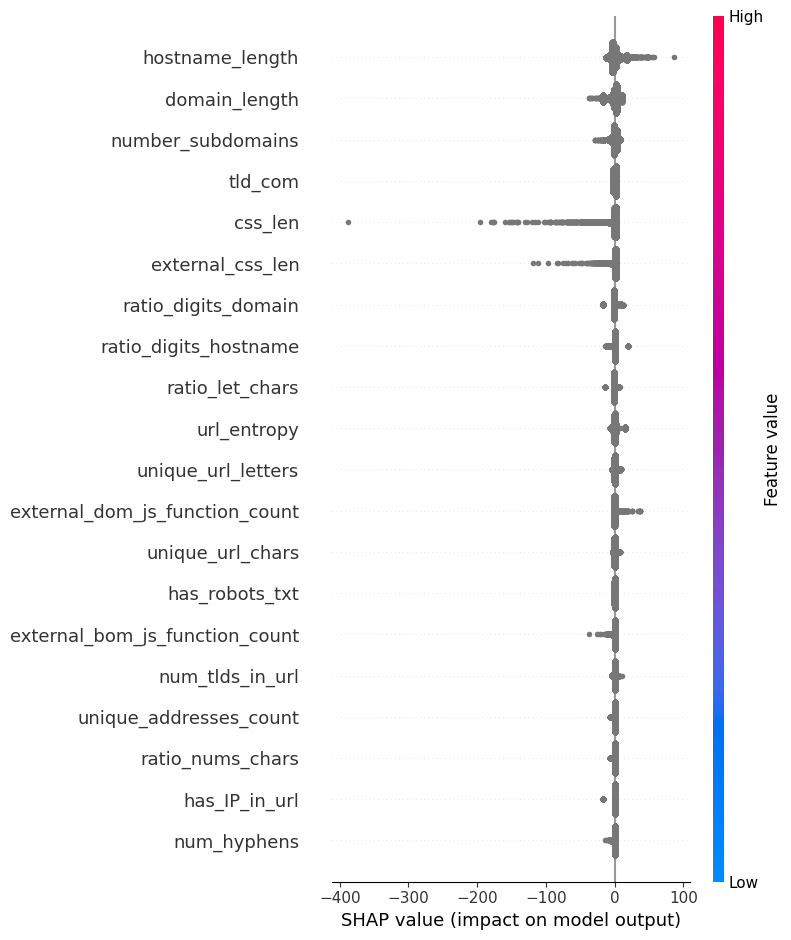

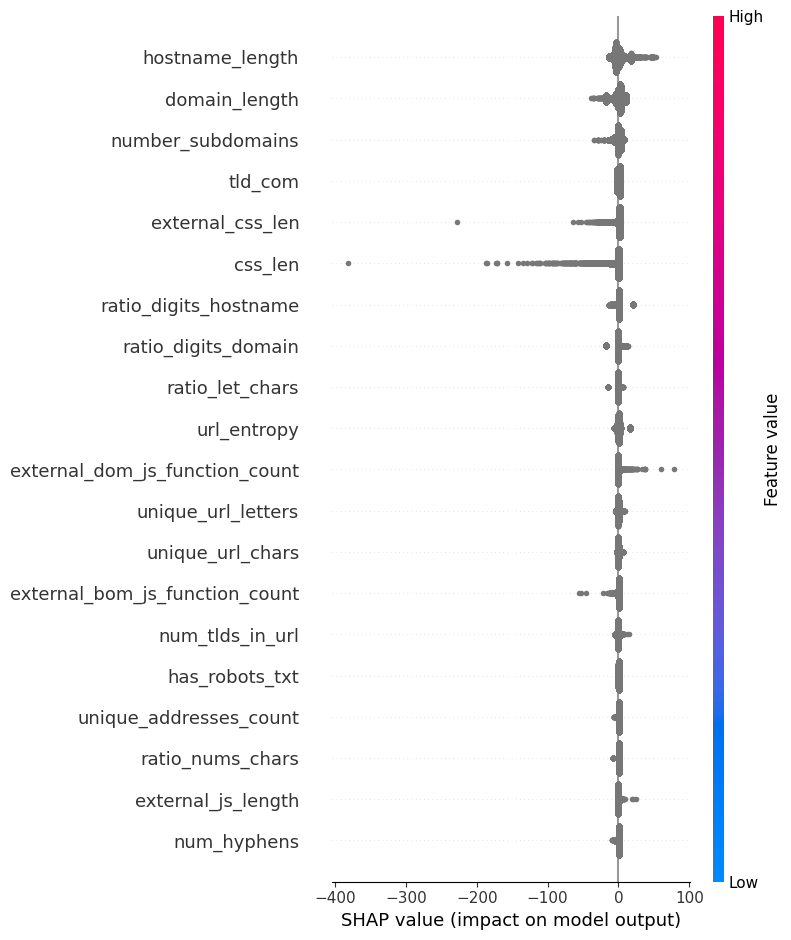

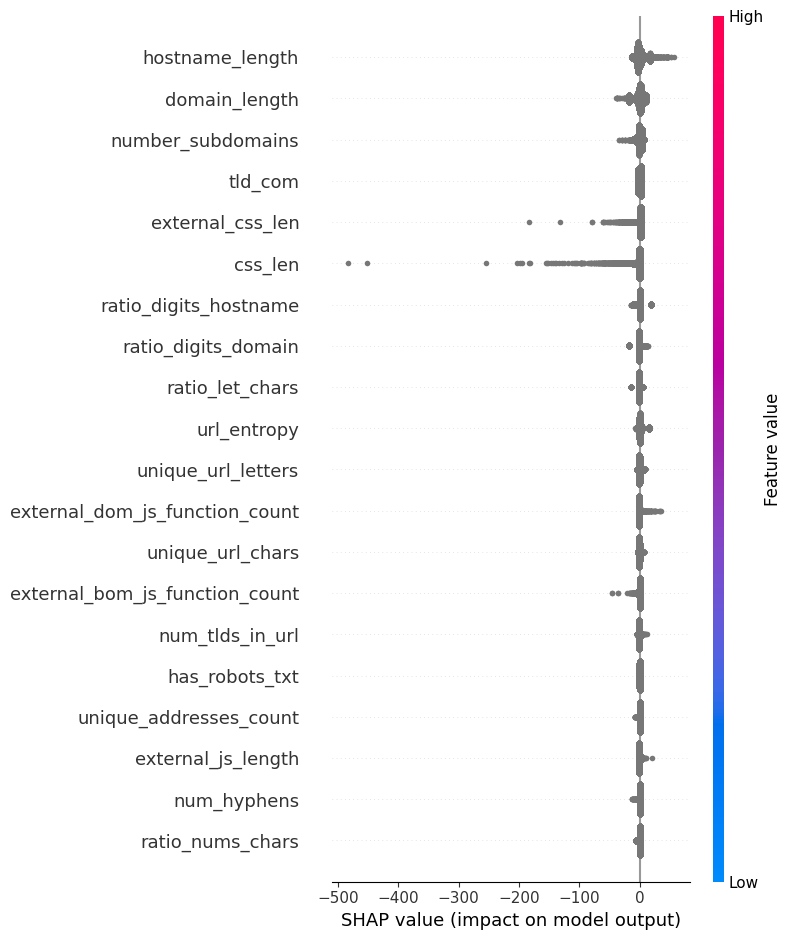

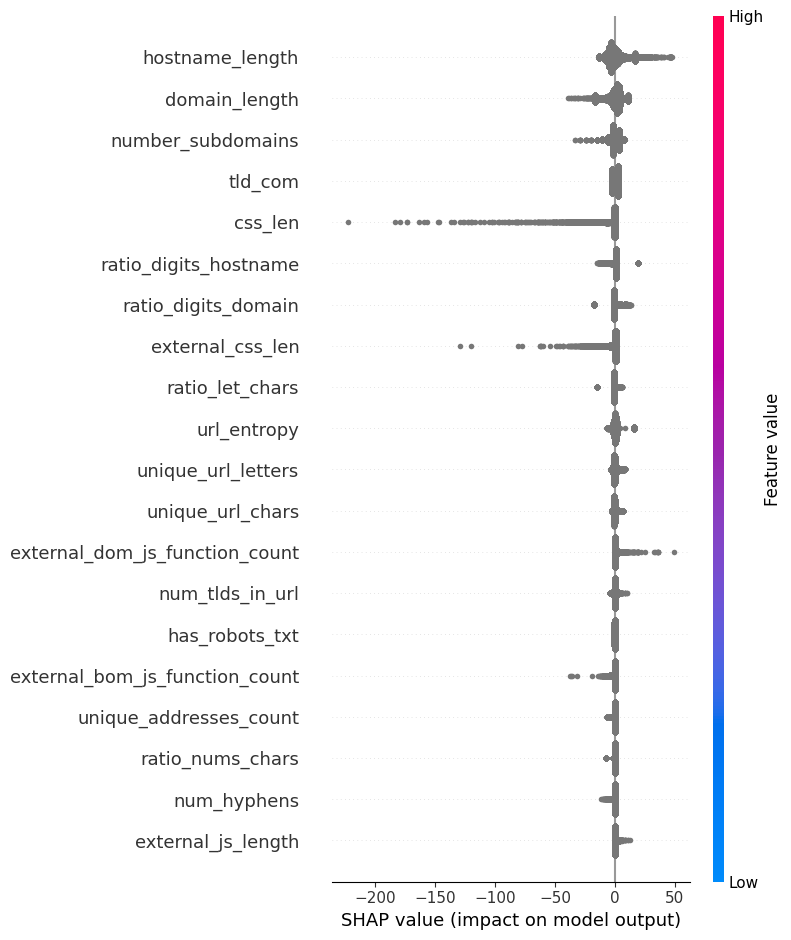

In [26]:
INPUT_FILE = "cascade_3.csv"
df = pd.read_csv(INPUT_FILE)

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict(X_test)

    explainer = shap.Explainer(lr, X_train, feature_names=features)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)

## All Features

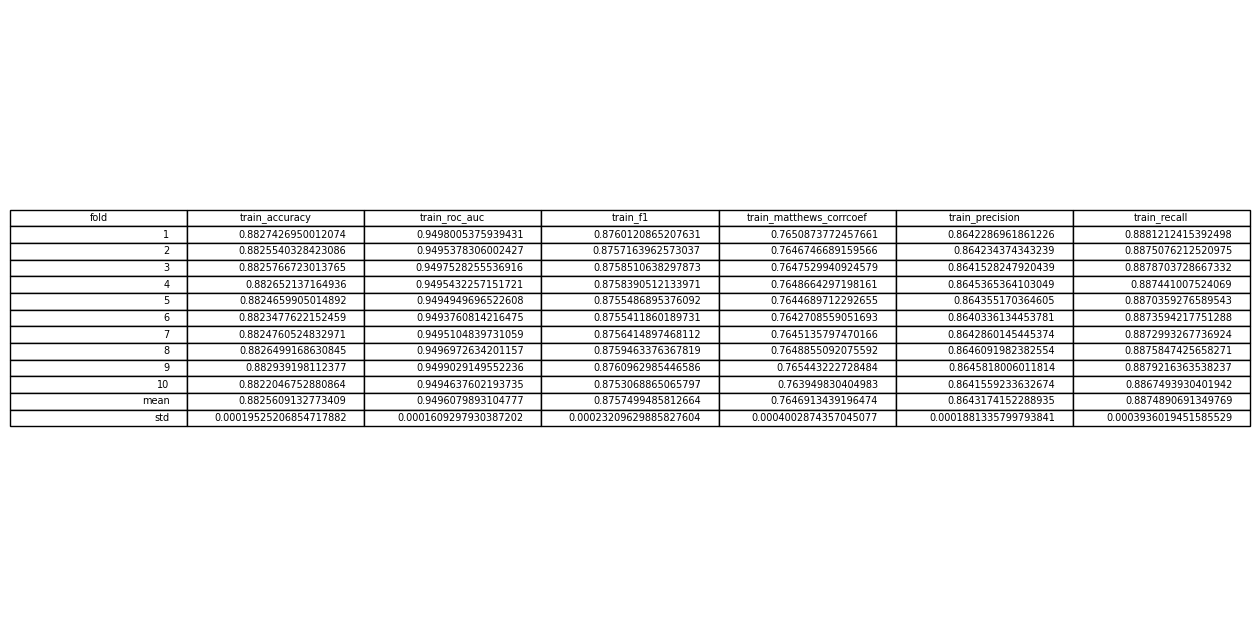

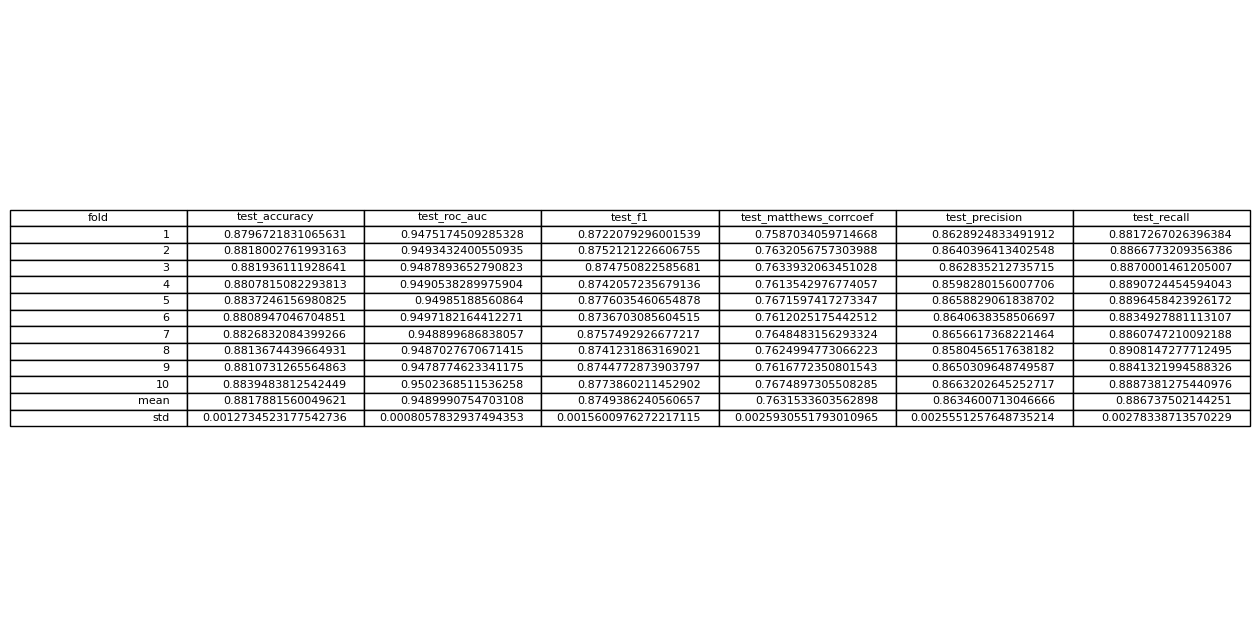

In [30]:
INPUT_FILE = "all_features.csv"
df = pd.read_csv(INPUT_FILE)

df['registrar'] = column_adjustor(df['registrar'])
df['ip_locations'] = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1' : 'f1',
    'matthews_corrcoef': 'matthews_corrcoef',
    'precision': 'precision',
    'recall': 'recall'
}

scores = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df = scores_df.drop(columns=['fit_time', 'score_time'])
mean = scores_df.mean()
scores_df.loc['mean'] = mean
std = scores_df.std()
scores_df.loc['std'] = std
scores_df['fold'] = [str(i + 1) for i in range(n_splits)] + ["mean", "std"]

train_scores = scores_df[['fold', 'train_accuracy', 'train_roc_auc', 'train_f1', 'train_matthews_corrcoef', 'train_precision', 'train_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = train_scores.values, colLabels = train_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"score_metrics_train_{INPUT_FILE.rstrip('.csv')}.png")

test_scores = scores_df[['fold', 'test_accuracy', 'test_roc_auc', 'test_f1', 'test_matthews_corrcoef', 'test_precision', 'test_recall']]
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis("off")
ax.axis("tight")
table = ax.table(cellText = test_scores.values, colLabels = test_scores.columns, loc="center")
fig.tight_layout
plt.savefig(f"lr_score_metrics_test_{INPUT_FILE.rstrip('.csv')}.png")

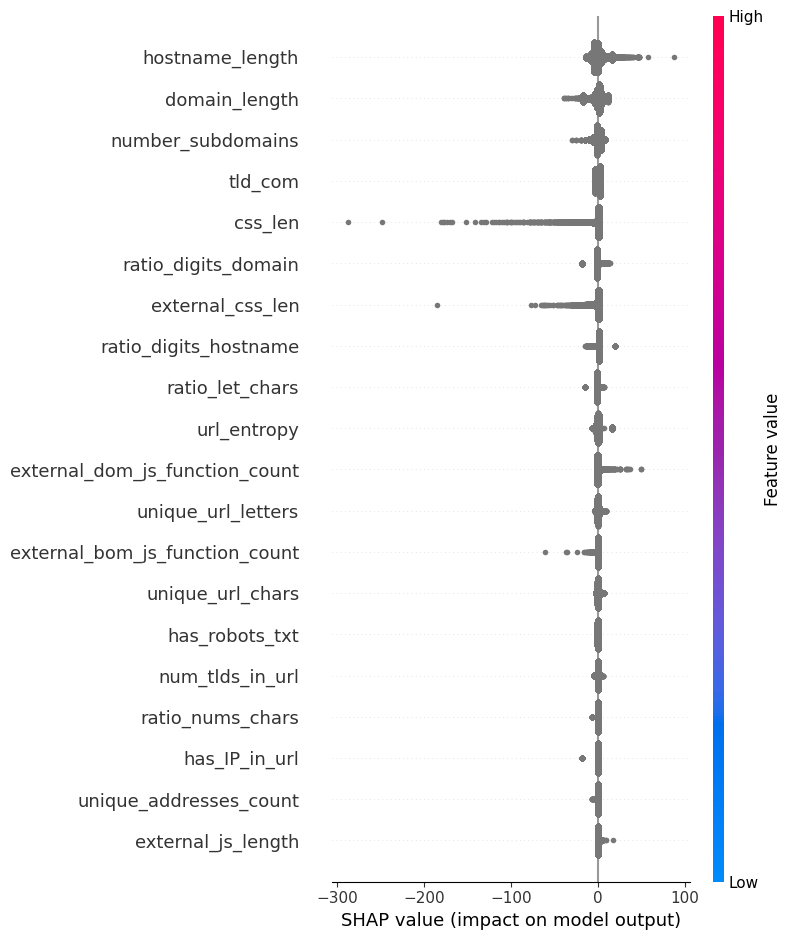

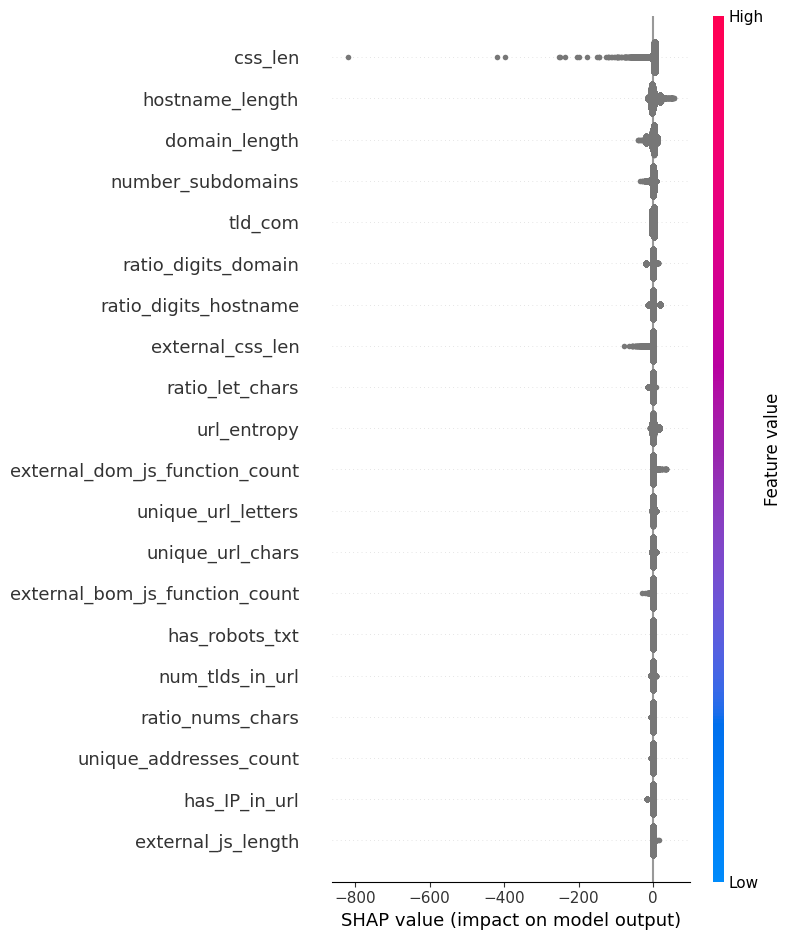

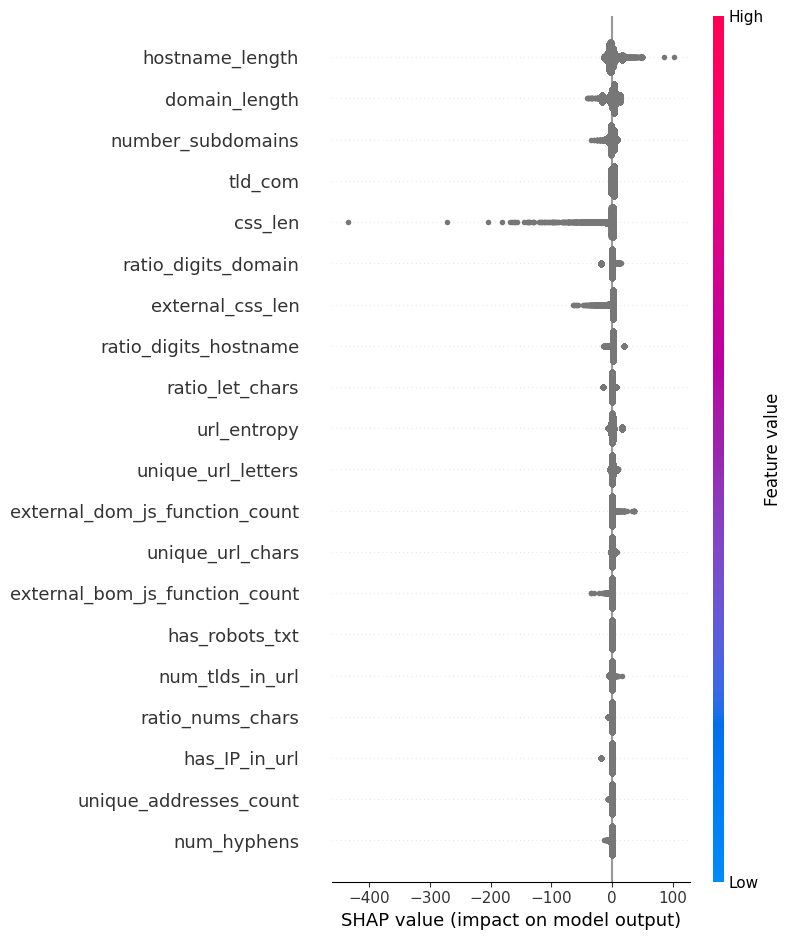

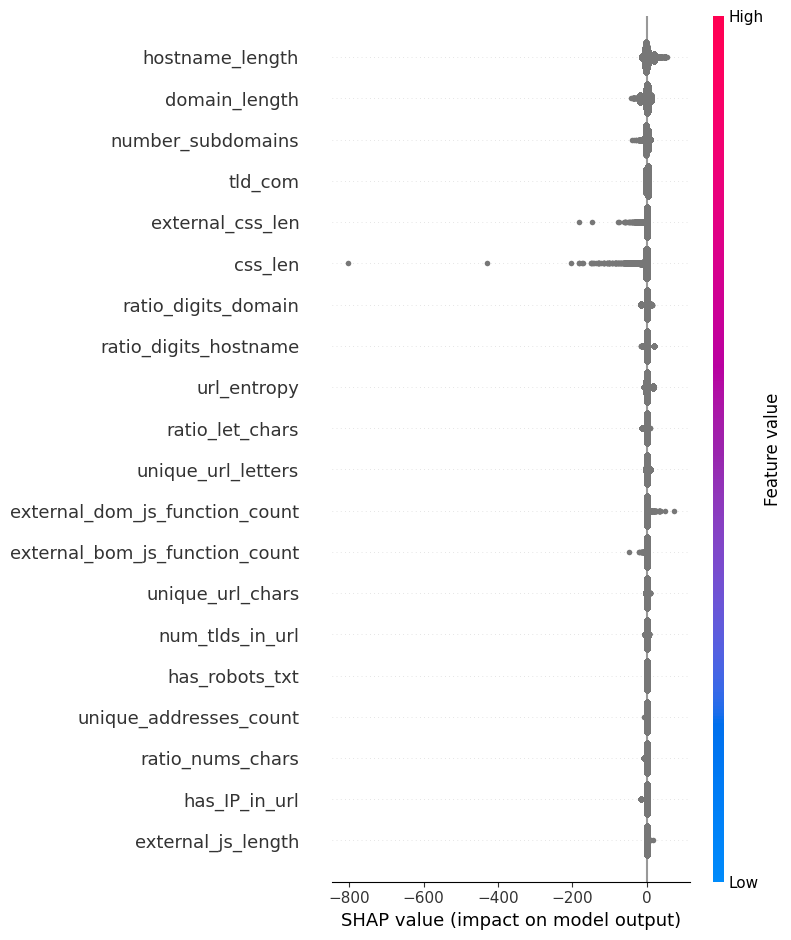

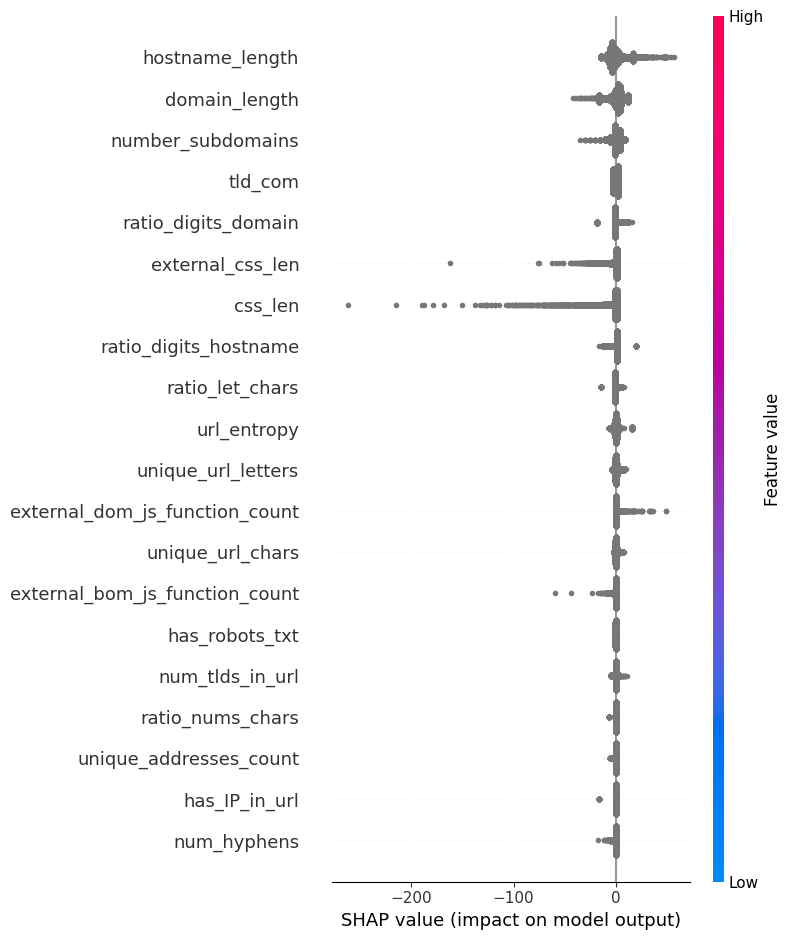

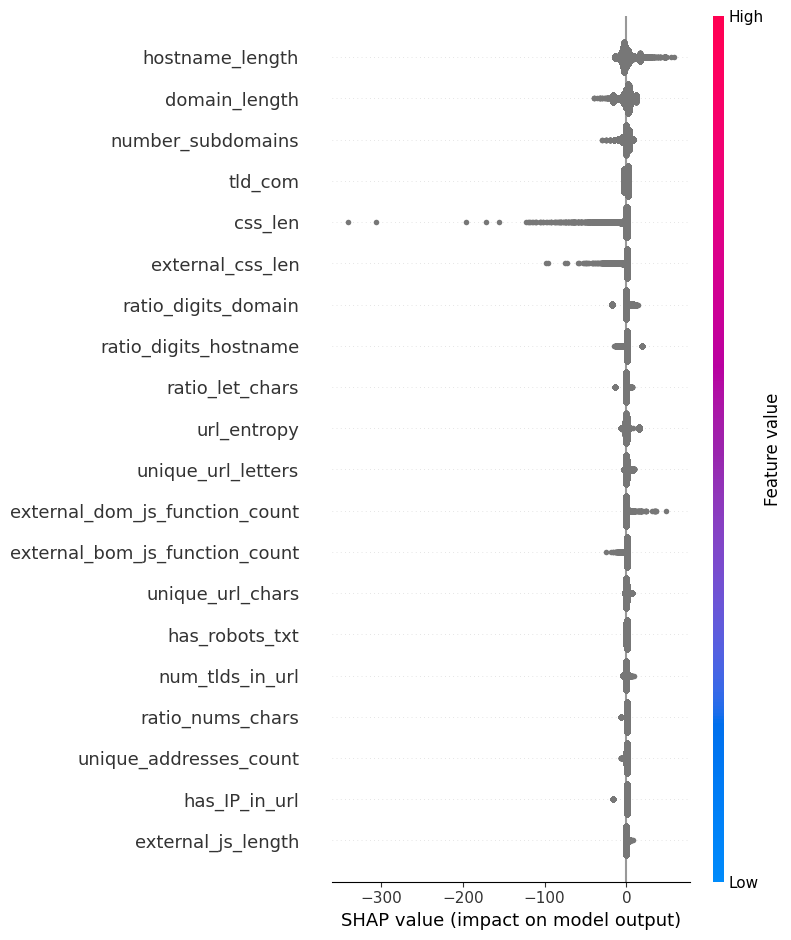

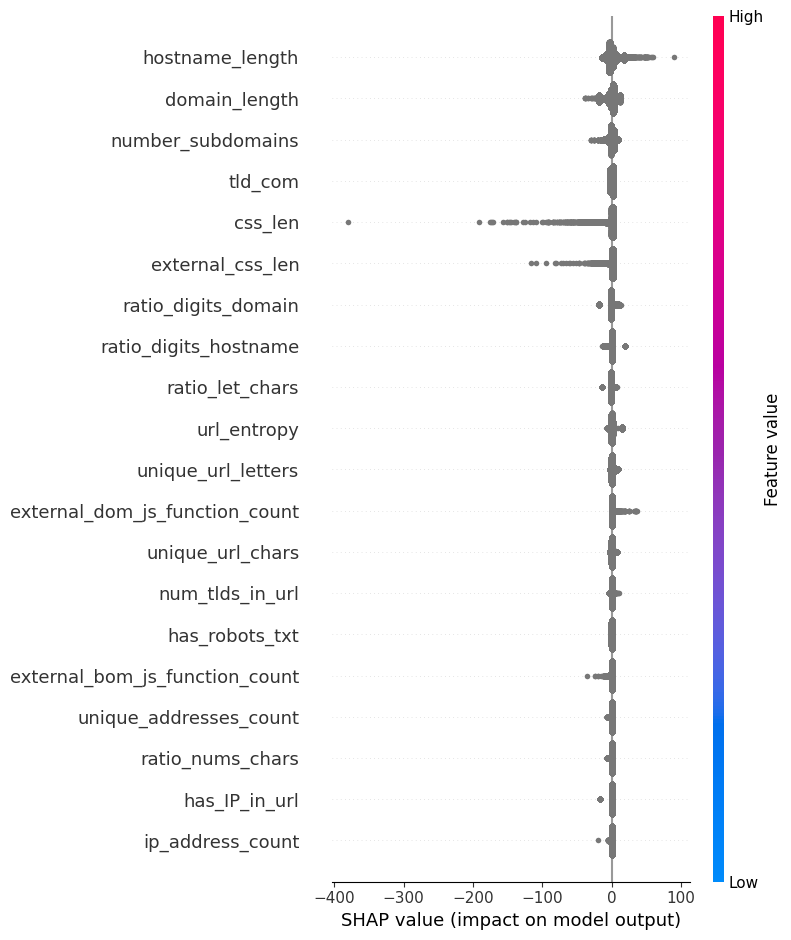

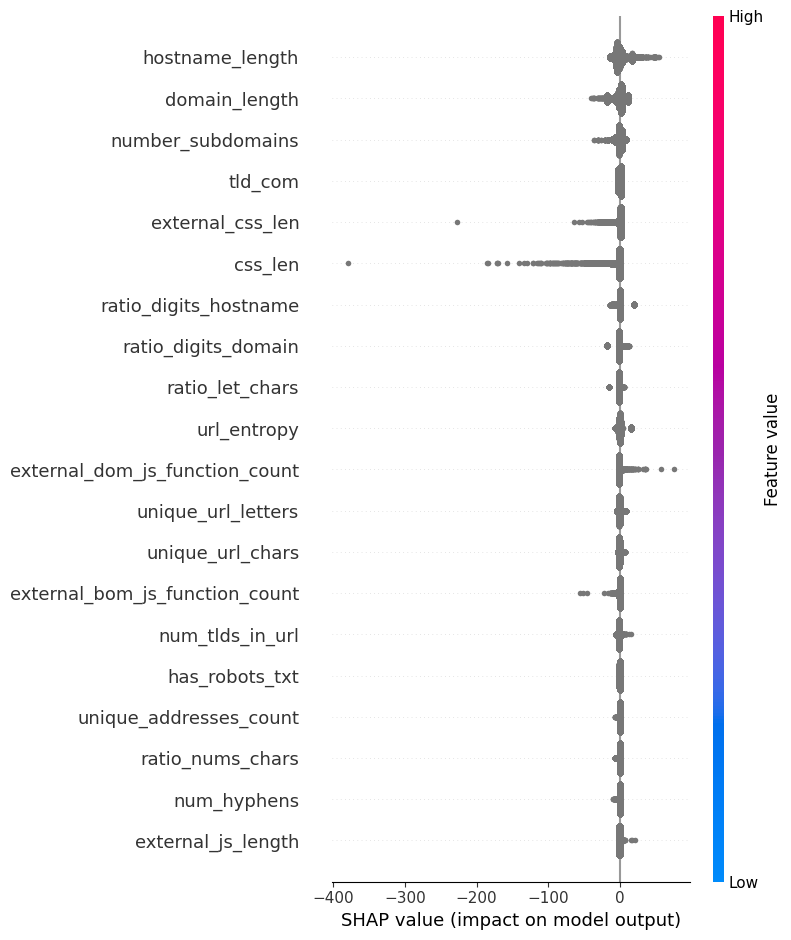

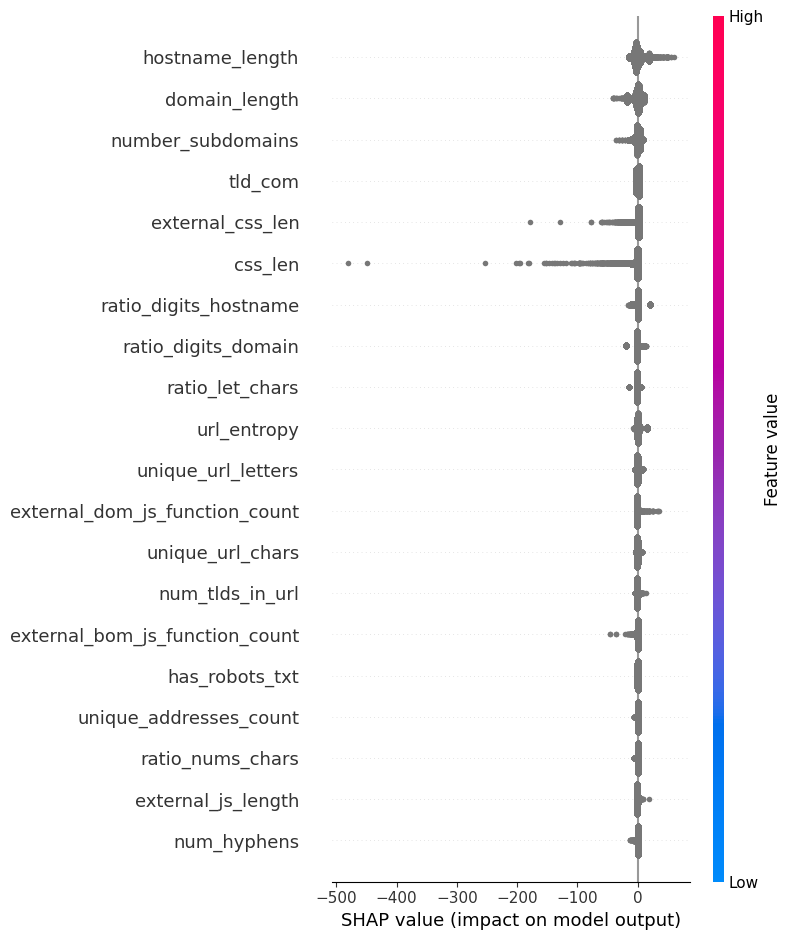

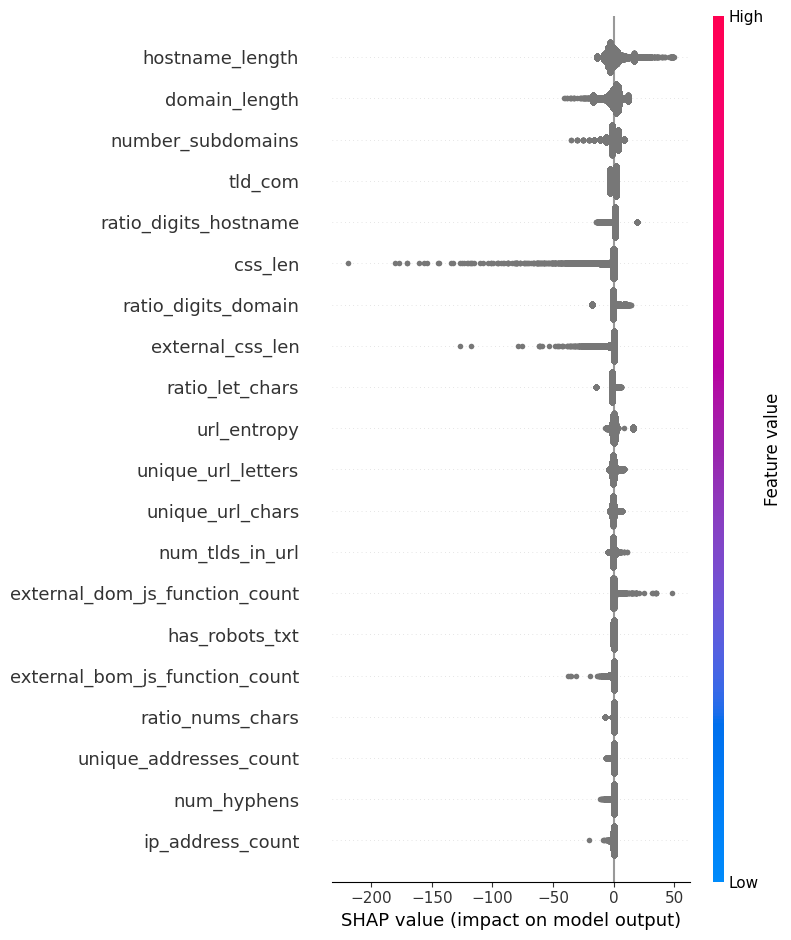

In [31]:
INPUT_FILE = "all_features.csv"
df = pd.read_csv(INPUT_FILE)

df['registrar'] = column_adjustor(df['registrar'])
df['ip_locations'] = column_adjustor(df['ip_locations'])

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)

df.loc[df['label'] == "good", 'label'] = 0 
df.loc[df['label'] != 0, 'label'] = 1

y = df['label'].astype(int)
X = df.drop(columns=['url', 'label', 'ip_address'])
X['tld'] = X['tld'].astype(str).fillna("unknown")
X = X.fillna(-1)

cols_to_categorize = ['tld']
numeric_cols = [col for col in X.columns if col not in cols_to_categorize]
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(drop="first"), cols_to_categorize)
    ]
)

X = preprocessor.fit_transform(X)
numeric_features = preprocessor.transformers_[0][1].get_feature_names_out(numeric_cols).tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(cols_to_categorize).tolist()
features = numeric_features + categorical_features

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict(X_test)

    explainer = shap.Explainer(lr, X_train, feature_names=features)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)